Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN: input 20 feats -> 64 conv channels
Epoch 1/100: train 0.3529 | val 0.4258
Epoch 2/100: train 0.1564 | val 0.1449
Epoch 3/100: train 0.1163 | val 0.1151
Epoch 4/100: train 0.1083 | val 0.0981
Epoch 5/100: train 0.0970 | val 0.1090
Epoch 6/100: train 0.0899 | val 0.0819
Epoch 7/100: train 0.0865 | val 0.0567
Epoch 8/100: train 0.0762 | val 0.1074
Epoch 9/100: train 0.0862 | val 0.1231
Epoch 10/100: train 0.0764 | val 0.0692
Epoch 11/100: train 0.0763 | val 0.0806
Epoch 12/100: train 0.0801 | val 0.0605
Epoch 13/100: train 0.0778 | val 0.0579
Epoch 14/100: train 0.0667 | val 0.0533
Epoch 15/100: train 0.0751 | val 0.0635
Epoch 16/100: train 0.0707 | val 0.0453
Epoch 17/100: train 0.0726 | val 0.0507
Epoch 18/100: train 0.0734 | val 0.0591
Epoch 19/100: train 0.0692 | val 0.0796
Epoch 20/100: train 0.0697 | val 0.0650
Epoch 21/100: train 0.0690 | val 0.0568
Epoch 22/100: train 0.0

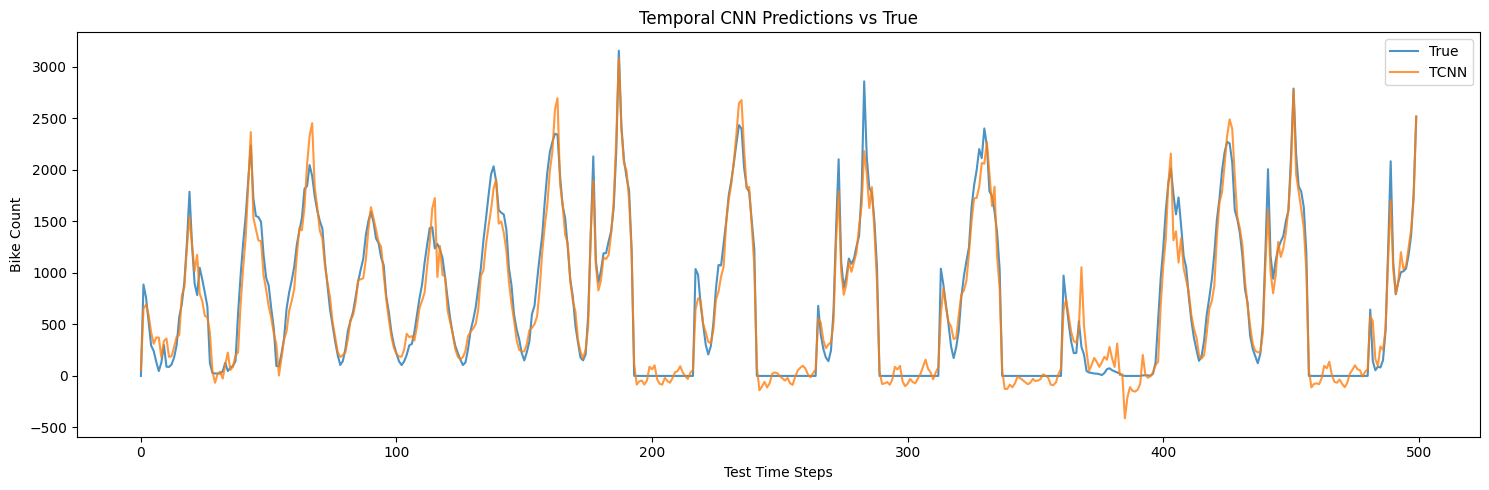

Temporal CNN training complete!


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN (TCNN) architecture ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=64, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.bn(x)
        x = torch.relu(x)
        x = x.mean(dim=2)                  # global avg pooling over time → [B, C]
        x = self.dropout(x)
        return self.fc(x)                  # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=64, dropout=0.3).to(device)
print(f"TemporalCNN: input {n_features} feats -> {64} conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN', alpha=0.8)
plt.legend()
plt.title('Temporal CNN Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN training complete!")


changing lr and or dropout

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN: input 20 feats -> 64 conv channels
Epoch 1/100: train 0.3397 | val 0.2825
Epoch 2/100: train 0.1333 | val 0.1103
Epoch 3/100: train 0.1021 | val 0.1482
Epoch 4/100: train 0.0861 | val 0.0773
Epoch 5/100: train 0.0774 | val 0.0745
Epoch 6/100: train 0.0799 | val 0.0706
Epoch 7/100: train 0.0694 | val 0.0598
Epoch 8/100: train 0.0619 | val 0.0574
Epoch 9/100: train 0.0686 | val 0.0539
Epoch 10/100: train 0.0617 | val 0.0507
Epoch 11/100: train 0.0636 | val 0.0593
Epoch 12/100: train 0.0619 | val 0.0519
Epoch 13/100: train 0.0644 | val 0.0761
Epoch 14/100: train 0.0617 | val 0.0536
Epoch 15/100: train 0.0611 | val 0.0489
Epoch 16/100: train 0.0565 | val 0.0495
Epoch 17/100: train 0.0621 | val 0.0612
Epoch 18/100: train 0.0584 | val 0.0537
Epoch 19/100: train 0.0572 | val 0.0682
Epoch 20/100: train 0.0591 | val 0.0607
Epoch 21/100: train 0.0562 | val 0.0420
Epoch 22/100: train 0.0

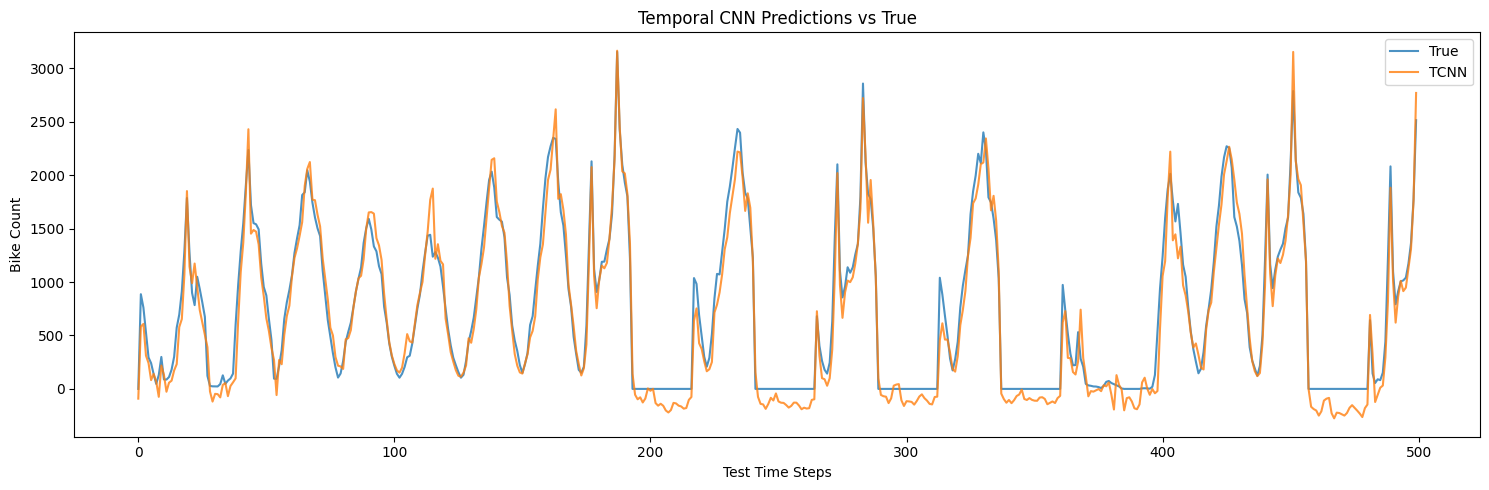

Temporal CNN training complete!


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN (TCNN) architecture ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=64, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.bn(x)
        x = torch.relu(x)
        x = x.mean(dim=2)                  # global avg pooling over time → [B, C]
        x = self.dropout(x)
        return self.fc(x)                  # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=64, dropout=0.2).to(device)
print(f"TemporalCNN: input {n_features} feats -> {64} conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN', alpha=0.8)
plt.legend()
plt.title('Temporal CNN Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN training complete!")


Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN: input 20 feats -> 64 conv channels
Epoch 1/100: train 0.5724 | val 0.6685
Epoch 2/100: train 0.3543 | val 0.4550
Epoch 3/100: train 0.2492 | val 0.3520
Epoch 4/100: train 0.2012 | val 0.3438
Epoch 5/100: train 0.1742 | val 0.2531
Epoch 6/100: train 0.1472 | val 0.2409
Epoch 7/100: train 0.1240 | val 0.2809
Epoch 8/100: train 0.1138 | val 0.1895
Epoch 9/100: train 0.1029 | val 0.1860
Epoch 10/100: train 0.1005 | val 0.1831
Epoch 11/100: train 0.0880 | val 0.1544
Epoch 12/100: train 0.0871 | val 0.1855
Epoch 13/100: train 0.0816 | val 0.1524
Epoch 14/100: train 0.0838 | val 0.2175
Epoch 15/100: train 0.0717 | val 0.1847
Epoch 16/100: train 0.0722 | val 0.1200
Epoch 17/100: train 0.0700 | val 0.1206
Epoch 18/100: train 0.0682 | val 0.1151
Epoch 19/100: train 0.0694 | val 0.1415
Epoch 20/100: train 0.0635 | val 0.1529
Epoch 21/100: train 0.0627 | val 0.1157
Epoch 22/100: train 0.0

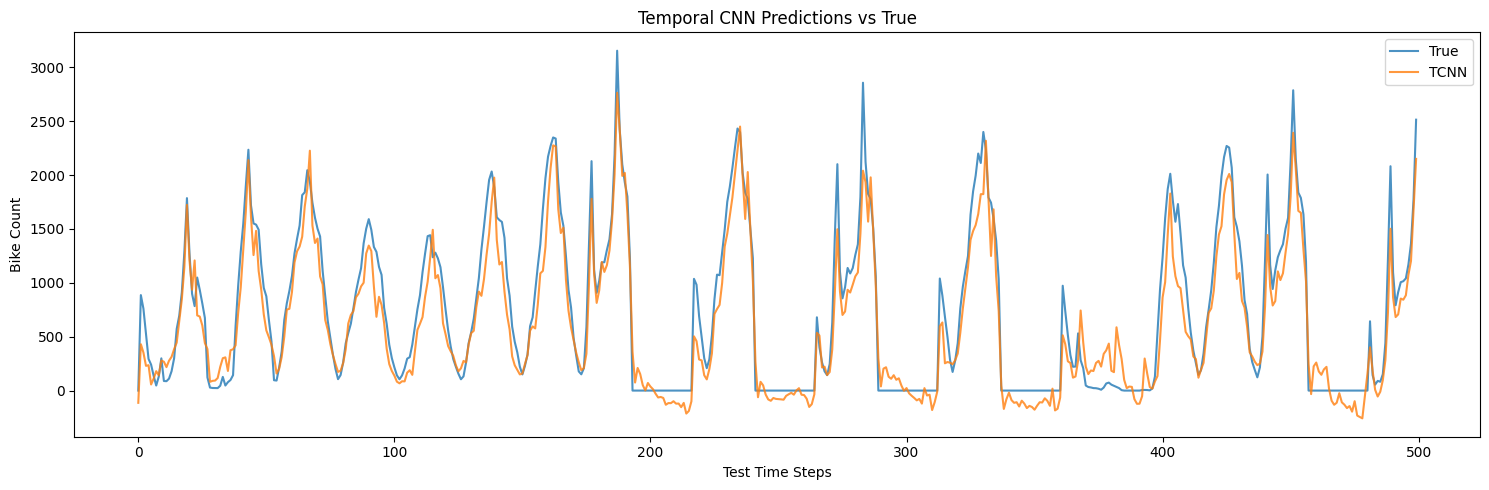

Temporal CNN training complete!


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN (TCNN) architecture ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=64, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.bn(x)
        x = torch.relu(x)
        x = x.mean(dim=2)                  # global avg pooling over time → [B, C]
        x = self.dropout(x)
        return self.fc(x)                  # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=64, dropout=0.2).to(device)
print(f"TemporalCNN: input {n_features} feats -> {64} conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN', alpha=0.8)
plt.legend()
plt.title('Temporal CNN Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN training complete!")


Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN: input 20 feats -> 64 conv channels
Epoch 1/100: train 0.5923 | val 0.6520
Epoch 2/100: train 0.3444 | val 0.4983
Epoch 3/100: train 0.2585 | val 0.4176
Epoch 4/100: train 0.2125 | val 0.3693
Epoch 5/100: train 0.1843 | val 0.3417
Epoch 6/100: train 0.1638 | val 0.2714
Epoch 7/100: train 0.1416 | val 0.2312
Epoch 8/100: train 0.1411 | val 0.2476
Epoch 9/100: train 0.1262 | val 0.1948
Epoch 10/100: train 0.1134 | val 0.2564
Epoch 11/100: train 0.1083 | val 0.2290
Epoch 12/100: train 0.1022 | val 0.1646
Epoch 13/100: train 0.0913 | val 0.1666
Epoch 14/100: train 0.0864 | val 0.1637
Epoch 15/100: train 0.0867 | val 0.1511
Epoch 16/100: train 0.0842 | val 0.1570
Epoch 17/100: train 0.0800 | val 0.1659
Epoch 18/100: train 0.0742 | val 0.1462
Epoch 19/100: train 0.0759 | val 0.1144
Epoch 20/100: train 0.0678 | val 0.1149
Epoch 21/100: train 0.0733 | val 0.1436
Epoch 22/100: train 0.0

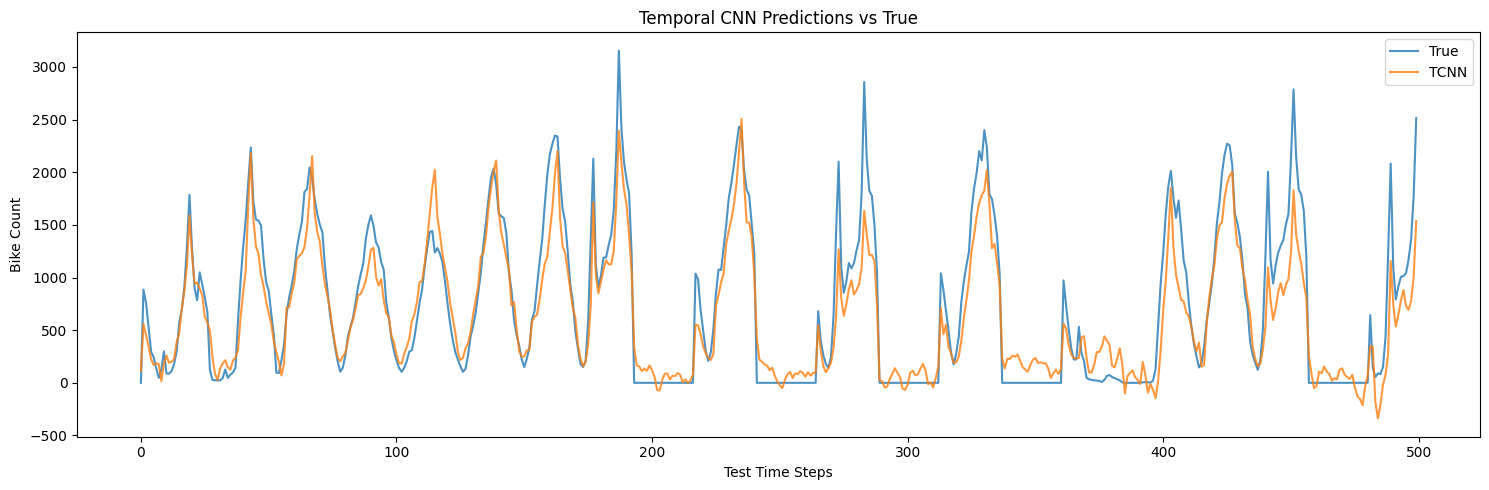

Temporal CNN training complete!


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN (TCNN) architecture ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=64, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.bn(x)
        x = torch.relu(x)
        x = x.mean(dim=2)                  # global avg pooling over time → [B, C]
        x = self.dropout(x)
        return self.fc(x)                  # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=64, dropout=0.3).to(device)
print(f"TemporalCNN: input {n_features} feats -> {64} conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN', alpha=0.8)
plt.legend()
plt.title('Temporal CNN Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN training complete!")


changing with lr and sropout didnot improve the model so adding another conv layer

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN: input 20 feats -> 64 conv channels
Epoch 1/100: train 0.3440 | val 0.3061
Epoch 2/100: train 0.1434 | val 0.1113
Epoch 3/100: train 0.1009 | val 0.0666
Epoch 4/100: train 0.0858 | val 0.0714
Epoch 5/100: train 0.0806 | val 0.0974
Epoch 6/100: train 0.0808 | val 0.1370
Epoch 7/100: train 0.0746 | val 0.0593
Epoch 8/100: train 0.0671 | val 0.0587
Epoch 9/100: train 0.0695 | val 0.0788
Epoch 10/100: train 0.0687 | val 0.0509
Epoch 11/100: train 0.0727 | val 0.0533
Epoch 12/100: train 0.0653 | val 0.0601
Epoch 13/100: train 0.0653 | val 0.0563
Epoch 14/100: train 0.0626 | val 0.0887
Epoch 15/100: train 0.0618 | val 0.0769
Epoch 16/100: train 0.0617 | val 0.0931
Epoch 17/100: train 0.0564 | val 0.0822
Epoch 18/100: train 0.0629 | val 0.0627
Epoch 19/100: train 0.0567 | val 0.0619
Epoch 20/100: train 0.0584 | val 0.0495
Epoch 21/100: train 0.0583 | val 0.0613
Epoch 22/100: train 0.0

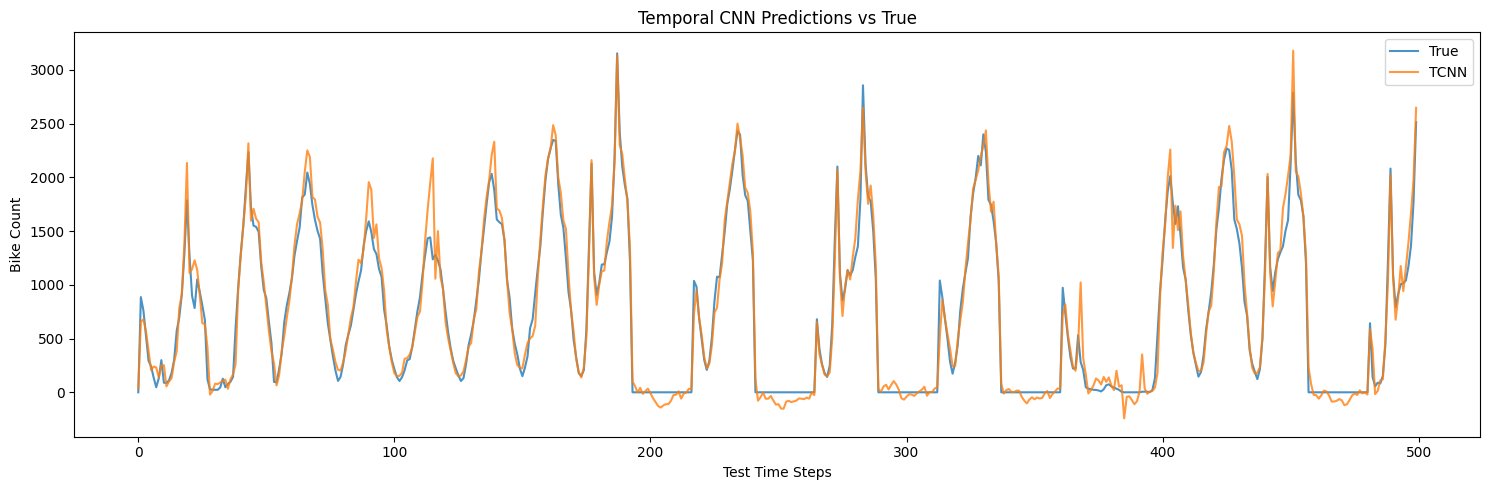

Temporal CNN training complete!


In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN (TCNN) architecture ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=64, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.bn(x)
        x = torch.relu(x)
        x = x.mean(dim=2)                  # global avg pooling over time → [B, C]
        x = self.dropout(x)
        return self.fc(x)                  # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=64, dropout=0.3).to(device)
print(f"TemporalCNN: input {n_features} feats -> {64} conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN', alpha=0.8)
plt.legend()
plt.title('Temporal CNN Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN training complete!")


Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN: input 20 feats -> 64 conv channels
Epoch 1/100: train 0.3272 | val 0.2466
Epoch 2/100: train 0.1380 | val 0.2145
Epoch 3/100: train 0.1066 | val 0.2163
Epoch 4/100: train 0.0934 | val 0.0826
Epoch 5/100: train 0.0861 | val 0.0669
Epoch 6/100: train 0.0782 | val 0.0630
Epoch 7/100: train 0.0768 | val 0.0850
Epoch 8/100: train 0.0794 | val 0.1415
Epoch 9/100: train 0.0777 | val 0.0579
Epoch 10/100: train 0.0792 | val 0.0862
Epoch 11/100: train 0.0695 | val 0.0736
Epoch 12/100: train 0.0715 | val 0.0865
Epoch 13/100: train 0.0680 | val 0.0612
Epoch 14/100: train 0.0712 | val 0.0793
Epoch 15/100: train 0.0691 | val 0.0507
Epoch 16/100: train 0.0730 | val 0.0708
Epoch 17/100: train 0.0611 | val 0.0532
Epoch 18/100: train 0.0627 | val 0.0481
Epoch 19/100: train 0.0579 | val 0.0492
Epoch 20/100: train 0.0654 | val 0.0516
Epoch 21/100: train 0.0594 | val 0.0486
Epoch 22/100: train 0.0

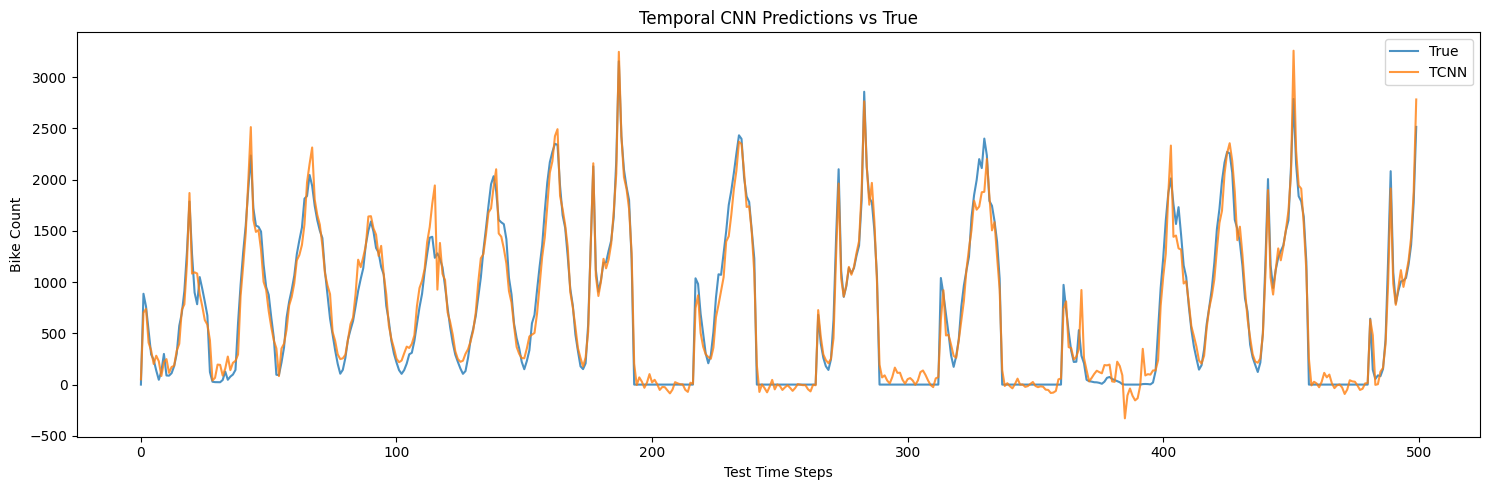

Temporal CNN training complete!


In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN (TCNN) architecture ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=80, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        # self.conv4 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        # x = torch.relu(self.conv4(x))
        x = self.bn(x)
        x = torch.relu(x)
        x = x.mean(dim=2)                  # global avg pooling over time → [B, C]
        x = self.dropout(x)
        return self.fc(x)                  # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=80, dropout=0.3).to(device)
print(f"TemporalCNN: input {n_features} feats -> {64} conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN', alpha=0.8)
plt.legend()
plt.title('Temporal CNN Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN training complete!")


Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN: input 20 feats -> 64 conv channels
Epoch 1/100: train 0.3065 | val 0.1608
Epoch 2/100: train 0.1102 | val 0.0969
Epoch 3/100: train 0.0912 | val 0.0942
Epoch 4/100: train 0.0812 | val 0.0684
Epoch 5/100: train 0.0777 | val 0.0691
Epoch 6/100: train 0.0717 | val 0.0991
Epoch 7/100: train 0.0706 | val 0.0728
Epoch 8/100: train 0.0750 | val 0.0572
Epoch 9/100: train 0.0709 | val 0.0633
Epoch 10/100: train 0.0720 | val 0.0557
Epoch 11/100: train 0.0677 | val 0.0504
Epoch 12/100: train 0.0634 | val 0.0448
Epoch 13/100: train 0.0655 | val 0.0633
Epoch 14/100: train 0.0600 | val 0.0494
Epoch 15/100: train 0.0671 | val 0.0674
Epoch 16/100: train 0.0645 | val 0.0595
Epoch 17/100: train 0.0608 | val 0.0594
Epoch 18/100: train 0.0616 | val 0.0516
Epoch 19/100: train 0.0604 | val 0.0549
Epoch 20/100: train 0.0579 | val 0.0540
Epoch 21/100: train 0.0566 | val 0.0530
Epoch 22/100: train 0.0

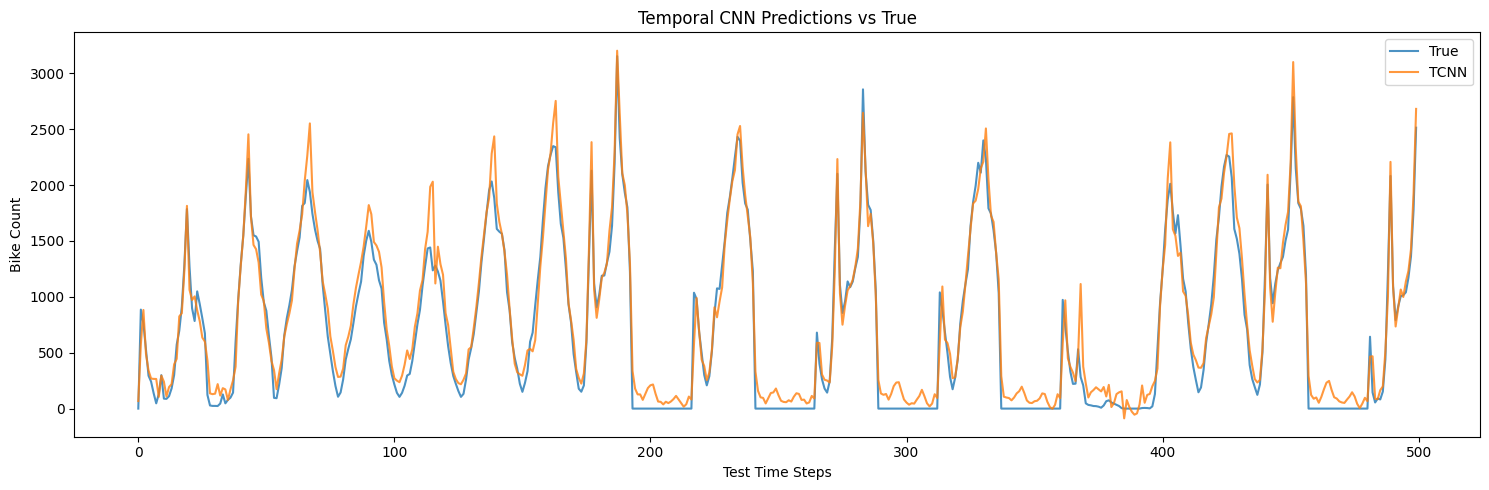

Temporal CNN training complete!


In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN (TCNN) architecture ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=96, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        # self.conv4 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        # x = torch.relu(self.conv4(x))
        x = self.bn(x)
        x = torch.relu(x)
        x = x.mean(dim=2)                  # global avg pooling over time → [B, C]
        x = self.dropout(x)
        return self.fc(x)                  # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=96, dropout=0.3).to(device)
print(f"TemporalCNN: input {n_features} feats -> {64} conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN', alpha=0.8)
plt.legend()
plt.title('Temporal CNN Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN training complete!")


changing the channles to 80 improved teh accuracy so now going to change the lr

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN: input 20 feats -> 64 conv channels
Epoch 1/100: train 0.3560 | val 0.2818
Epoch 2/100: train 0.1500 | val 0.1682
Epoch 3/100: train 0.1079 | val 0.0939
Epoch 4/100: train 0.0984 | val 0.1056
Epoch 5/100: train 0.0935 | val 0.0583
Epoch 6/100: train 0.0867 | val 0.0504
Epoch 7/100: train 0.0802 | val 0.1117
Epoch 8/100: train 0.0748 | val 0.0684
Epoch 9/100: train 0.0788 | val 0.0582
Epoch 10/100: train 0.0872 | val 0.0584
Epoch 11/100: train 0.0708 | val 0.0655
Epoch 12/100: train 0.0752 | val 0.0701
Epoch 13/100: train 0.0752 | val 0.0583
Epoch 14/100: train 0.0691 | val 0.0756
Epoch 15/100: train 0.0745 | val 0.0453
Epoch 16/100: train 0.0714 | val 0.0628
Epoch 17/100: train 0.0746 | val 0.0491
Epoch 18/100: train 0.0748 | val 0.0430
Epoch 19/100: train 0.0637 | val 0.0447
Epoch 20/100: train 0.0704 | val 0.0476
Epoch 21/100: train 0.0690 | val 0.0581
Epoch 22/100: train 0.0

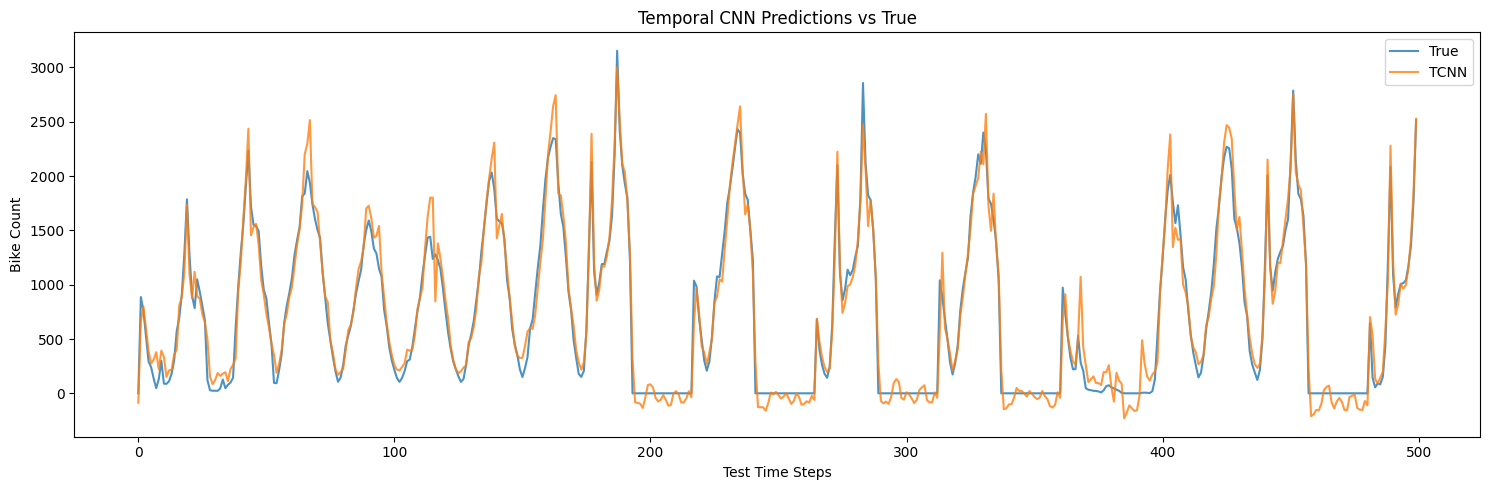

Temporal CNN training complete!


In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN (TCNN) architecture ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=80, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        # self.conv4 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        # x = torch.relu(self.conv4(x))
        x = self.bn(x)
        x = torch.relu(x)
        x = x.mean(dim=2)                  # global avg pooling over time → [B, C]
        x = self.dropout(x)
        return self.fc(x)                  # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=80, dropout=0.3).to(device)
print(f"TemporalCNN: input {n_features} feats -> {64} conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN', alpha=0.8)
plt.legend()
plt.title('Temporal CNN Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN training complete!")


Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN: input 20 feats -> 64 conv channels
Epoch 1/100: train 0.3291 | val 0.2768
Epoch 2/100: train 0.1552 | val 0.1658
Epoch 3/100: train 0.1118 | val 0.1161
Epoch 4/100: train 0.0947 | val 0.0894
Epoch 5/100: train 0.0918 | val 0.0670
Epoch 6/100: train 0.0859 | val 0.0606
Epoch 7/100: train 0.0815 | val 0.0553
Epoch 8/100: train 0.0810 | val 0.0501
Epoch 9/100: train 0.0838 | val 0.0730
Epoch 10/100: train 0.0839 | val 0.0564
Epoch 11/100: train 0.0843 | val 0.0606
Epoch 12/100: train 0.0838 | val 0.0498
Epoch 13/100: train 0.0854 | val 0.0530
Epoch 14/100: train 0.0800 | val 0.0562
Epoch 15/100: train 0.0745 | val 0.0537
Epoch 16/100: train 0.0791 | val 0.0510
Epoch 17/100: train 0.0731 | val 0.0502
Epoch 18/100: train 0.0729 | val 0.0533
Epoch 19/100: train 0.0760 | val 0.0492
Epoch 20/100: train 0.0749 | val 0.0580
Epoch 21/100: train 0.0706 | val 0.0487
Epoch 22/100: train 0.0

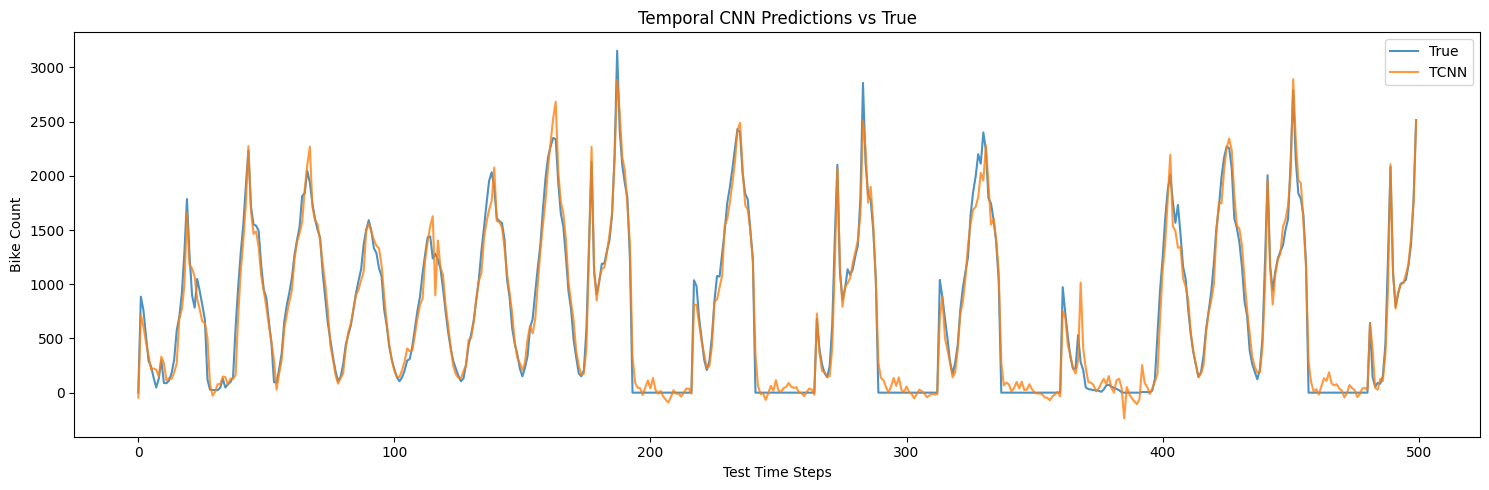

Temporal CNN training complete!


In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN (TCNN) architecture ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=80, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        # self.conv4 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        # x = torch.relu(self.conv4(x))
        x = self.bn(x)
        x = torch.relu(x)
        x = x.mean(dim=2)                  # global avg pooling over time → [B, C]
        x = self.dropout(x)
        return self.fc(x)                  # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=80, dropout=0.3).to(device)
print(f"TemporalCNN: input {n_features} feats -> {64} conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN', alpha=0.8)
plt.legend()
plt.title('Temporal CNN Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN training complete!")


Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN: input 20 feats -> 64 conv channels
Epoch 1/100: train 0.5576 | val 0.6535
Epoch 2/100: train 0.3340 | val 0.4752
Epoch 3/100: train 0.2276 | val 0.3042
Epoch 4/100: train 0.1806 | val 0.2489
Epoch 5/100: train 0.1499 | val 0.2358
Epoch 6/100: train 0.1266 | val 0.2741
Epoch 7/100: train 0.1072 | val 0.1380
Epoch 8/100: train 0.0968 | val 0.1595
Epoch 9/100: train 0.0885 | val 0.2024
Epoch 10/100: train 0.0833 | val 0.1574
Epoch 11/100: train 0.0765 | val 0.1571
Epoch 12/100: train 0.0720 | val 0.1202
Epoch 13/100: train 0.0716 | val 0.1492
Epoch 14/100: train 0.0689 | val 0.1095
Epoch 15/100: train 0.0673 | val 0.0814
Epoch 16/100: train 0.0640 | val 0.0941
Epoch 17/100: train 0.0645 | val 0.0911
Epoch 18/100: train 0.0651 | val 0.0938
Epoch 19/100: train 0.0619 | val 0.1150
Epoch 20/100: train 0.0609 | val 0.1063
Epoch 21/100: train 0.0584 | val 0.1007
Epoch 22/100: train 0.0

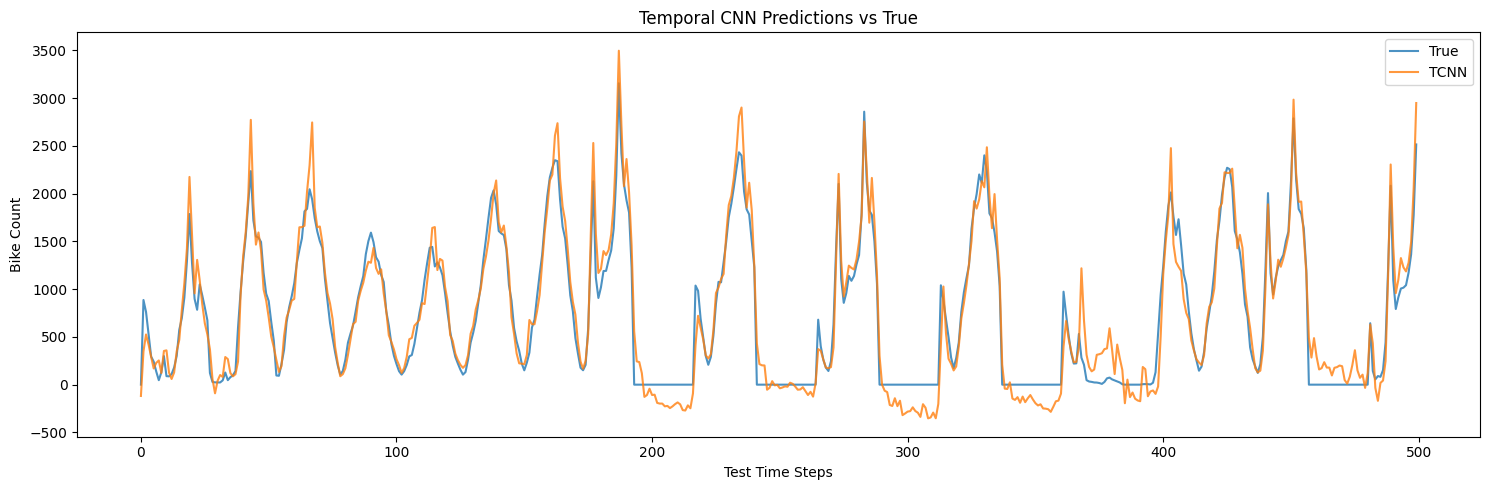

Temporal CNN training complete!


In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN (TCNN) architecture ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=80, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        # self.conv4 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        # x = torch.relu(self.conv4(x))
        x = self.bn(x)
        x = torch.relu(x)
        x = x.mean(dim=2)                  # global avg pooling over time → [B, C]
        x = self.dropout(x)
        return self.fc(x)                  # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=80, dropout=0.3).to(device)
print(f"TemporalCNN: input {n_features} feats -> {64} conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN', alpha=0.8)
plt.legend()
plt.title('Temporal CNN Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN training complete!")


Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN: input 20 feats -> 64 conv channels
Epoch 1/100: train 0.3091 | val 0.2236
Epoch 2/100: train 0.1258 | val 0.1109
Epoch 3/100: train 0.1191 | val 0.0942
Epoch 4/100: train 0.0973 | val 0.0675
Epoch 5/100: train 0.0989 | val 0.0855
Epoch 6/100: train 0.0870 | val 0.0951
Epoch 7/100: train 0.0822 | val 0.0536
Epoch 8/100: train 0.0807 | val 0.0608
Epoch 9/100: train 0.0741 | val 0.0495
Epoch 10/100: train 0.0860 | val 0.0477
Epoch 11/100: train 0.0761 | val 0.0583
Epoch 12/100: train 0.0831 | val 0.0519
Epoch 13/100: train 0.0783 | val 0.0675
Epoch 14/100: train 0.0744 | val 0.0432
Epoch 15/100: train 0.0795 | val 0.0503
Epoch 16/100: train 0.0779 | val 0.0614
Epoch 17/100: train 0.0797 | val 0.0492
Epoch 18/100: train 0.0745 | val 0.0464
Epoch 19/100: train 0.0733 | val 0.0421
Epoch 20/100: train 0.0706 | val 0.0471
Epoch 21/100: train 0.0700 | val 0.0584
Epoch 22/100: train 0.0

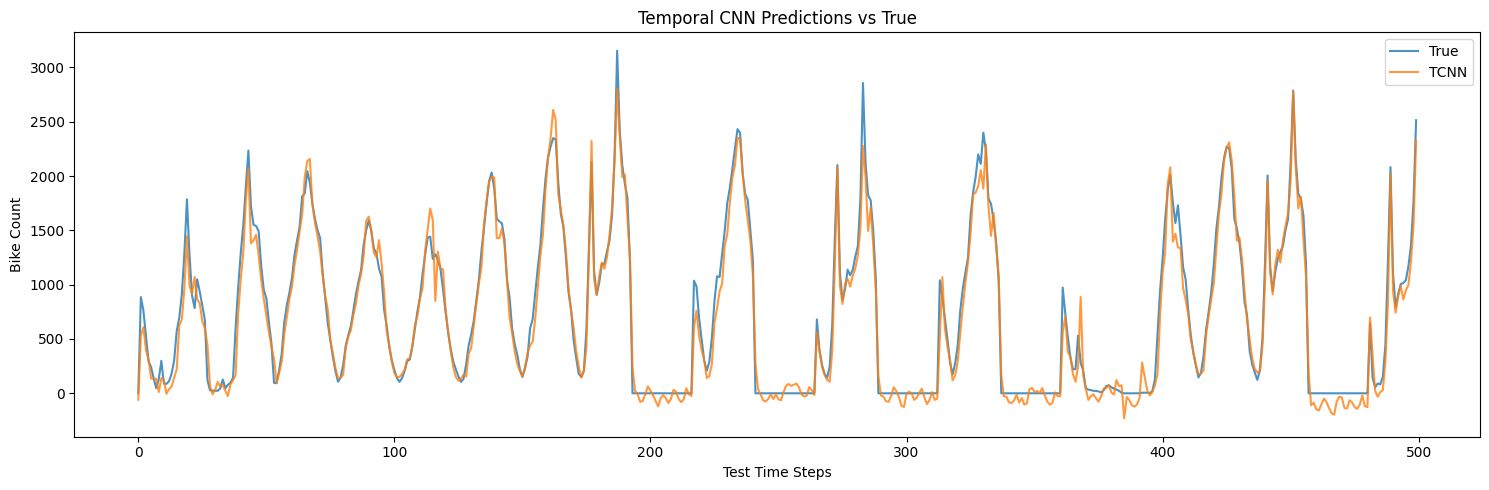

Temporal CNN training complete!


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN (TCNN) architecture ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=80, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        # self.conv4 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        # x = torch.relu(self.conv4(x))
        x = self.bn(x)
        x = torch.relu(x)
        x = x.mean(dim=2)                  # global avg pooling over time → [B, C]
        x = self.dropout(x)
        return self.fc(x)                  # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=80, dropout=0.3).to(device)
print(f"TemporalCNN: input {n_features} feats -> {64} conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN', alpha=0.8)
plt.legend()
plt.title('Temporal CNN Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN training complete!")


adding LSTM to this architecure to see how it changes

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
CNN→LSTM: 20 feats -> 80 conv ch -> 80 LSTM hidden
Epoch 1/100: train 0.1552 | val 0.2119
Epoch 2/100: train 0.0881 | val 0.0875
Epoch 3/100: train 0.0581 | val 0.0737
Epoch 4/100: train 0.0517 | val 0.0605
Epoch 5/100: train 0.0462 | val 0.0499
Epoch 6/100: train 0.0408 | val 0.0651
Epoch 7/100: train 0.0434 | val 0.0914
Epoch 8/100: train 0.0386 | val 0.0548
Epoch 9/100: train 0.0377 | val 0.0490
Epoch 10/100: train 0.0375 | val 0.0444
Epoch 11/100: train 0.0341 | val 0.0474
Epoch 12/100: train 0.0339 | val 0.0567
Epoch 13/100: train 0.0340 | val 0.0496
Epoch 14/100: train 0.0339 | val 0.0473
Epoch 15/100: train 0.0345 | val 0.0438
Epoch 16/100: train 0.0324 | val 0.0487
Epoch 17/100: train 0.0321 | val 0.0515
Epoch 18/100: train 0.0309 | val 0.0444
Epoch 19/100: train 0.0332 | val 0.0458
Epoch 20/100: train 0.0316 | val 0.0559
Epoch 21/100: train 0.0324 | val 0.0442
Epoch 22/100: train 

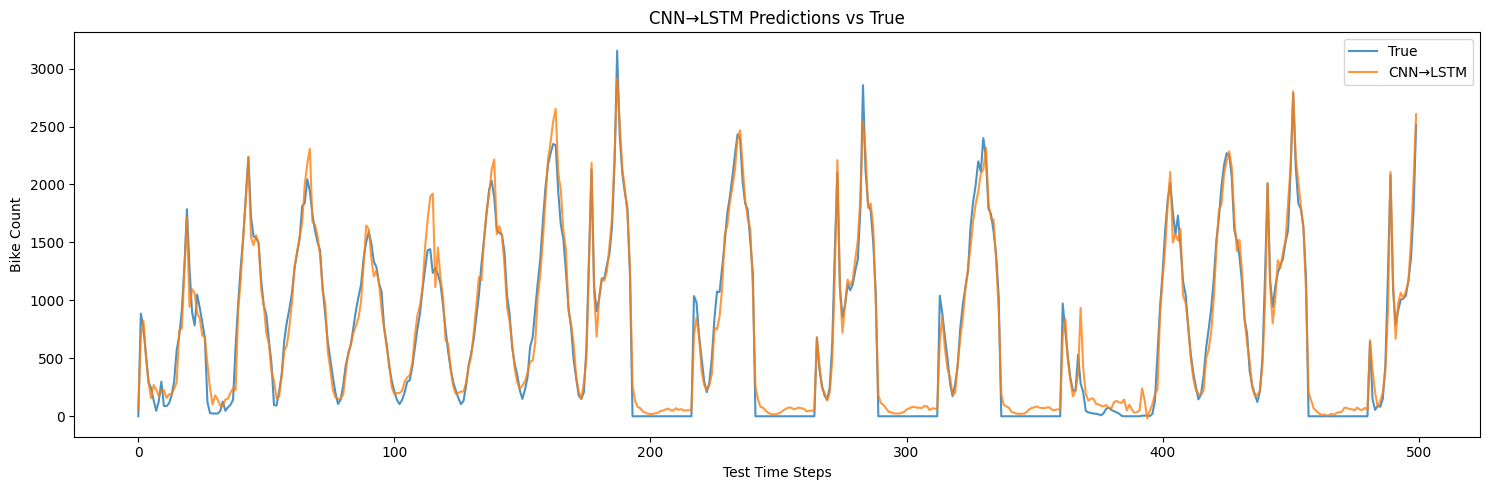

CNN→LSTM training complete!


In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- CNN → LSTM hybrid architecture ---
class CNNLSTM(nn.Module):
    def __init__(self, input_size, conv_channels=80, lstm_hidden=80,
                 num_lstm_layers=1, dropout=0.3):
        super().__init__()
        # CNN part
        self.conv1 = nn.Conv1d(input_size, conv_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(conv_channels, conv_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(conv_channels, conv_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(conv_channels)

        # LSTM part
        self.lstm = nn.LSTM(
            input_size=conv_channels,
            hidden_size=lstm_hidden,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout if num_lstm_layers > 1 else 0.0
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        # x: [B, T, F]
        # CNN over time
        x = x.transpose(1, 2)            # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.bn(x)
        x = torch.relu(x)                # [B, C, T]

        # LSTM: [B, T, C]
        x = x.transpose(1, 2)            # [B, T, C]
        lstm_out, (h_n, c_n) = self.lstm(x)
        final_h = h_n[-1]                # [B, H]

        final_h = self.dropout(final_h)
        return self.fc(final_h)          # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNLSTM(
    input_size=n_features,
    conv_channels=80,
    lstm_hidden=80,
    num_lstm_layers=1,
    dropout=0.3
).to(device)

print(f"CNN→LSTM: {n_features} feats -> 80 conv ch -> 80 LSTM hidden")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== CNN→LSTM TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== CNN→LSTM TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='CNN→LSTM', alpha=0.8)
plt.legend()
plt.title('CNN→LSTM Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("CNN→LSTM training complete!")


Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN (avg+max): input 20 feats -> 80 conv channels
Epoch 1/100: train 0.3906 | val 0.2342
Epoch 2/100: train 0.2019 | val 0.1034
Epoch 3/100: train 0.1656 | val 0.0989
Epoch 4/100: train 0.1277 | val 0.0844
Epoch 5/100: train 0.1083 | val 0.0927
Epoch 6/100: train 0.0985 | val 0.0949
Epoch 7/100: train 0.0918 | val 0.0841
Epoch 8/100: train 0.1047 | val 0.0664
Epoch 9/100: train 0.0818 | val 0.0544
Epoch 10/100: train 0.0789 | val 0.0639
Epoch 11/100: train 0.0814 | val 0.0538
Epoch 12/100: train 0.0700 | val 0.0577
Epoch 13/100: train 0.0725 | val 0.0554
Epoch 14/100: train 0.0642 | val 0.0753
Epoch 15/100: train 0.0617 | val 0.0696
Epoch 16/100: train 0.0619 | val 0.0553
Epoch 17/100: train 0.0644 | val 0.0491
Epoch 18/100: train 0.0528 | val 0.0686
Epoch 19/100: train 0.0618 | val 0.0587
Epoch 20/100: train 0.0534 | val 0.0542
Epoch 21/100: train 0.0541 | val 0.0545
Epoch 22/100:

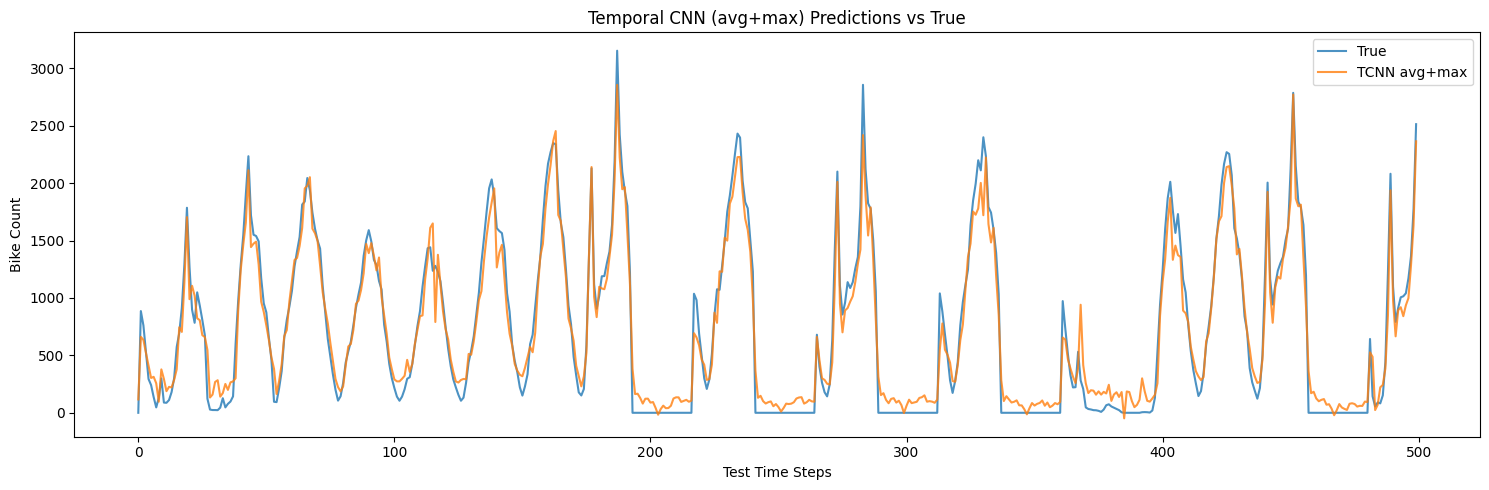

Temporal CNN (avg+max) training complete!


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN with avg + max pooling ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=80, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(2 * channels, 1)  

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.bn(x)
        x = torch.relu(x)                  # [B, C, T]

        avg_pool = x.mean(dim=2)           # [B, C]
        max_pool, _ = x.max(dim=2)         # [B, C]
        feats = torch.cat([avg_pool, max_pool], dim=1)  # [B, 2C]

        feats = self.dropout(feats)
        return self.fc(feats)              # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=80, dropout=0.3).to(device)
print(f"TemporalCNN (avg+max): input {n_features} feats -> 80 conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN (avg+max) TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN (avg+max) TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN avg+max', alpha=0.8)
plt.legend()
plt.title('Temporal CNN (avg+max) Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN (avg+max) training complete!")


Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN (avg+max): input 20 feats -> 80 conv channels
Epoch 1/100: train 0.4041 | val 0.1797
Epoch 2/100: train 0.1980 | val 0.1646
Epoch 3/100: train 0.1607 | val 0.1083
Epoch 4/100: train 0.1351 | val 0.0791
Epoch 5/100: train 0.1249 | val 0.0637
Epoch 6/100: train 0.1046 | val 0.1281
Epoch 7/100: train 0.1177 | val 0.0667
Epoch 8/100: train 0.0994 | val 0.0896
Epoch 9/100: train 0.0824 | val 0.0543
Epoch 10/100: train 0.0815 | val 0.0938
Epoch 11/100: train 0.0758 | val 0.0569
Epoch 12/100: train 0.0741 | val 0.0769
Epoch 13/100: train 0.0725 | val 0.0576
Epoch 14/100: train 0.0729 | val 0.1366
Epoch 15/100: train 0.0648 | val 0.0602
Epoch 16/100: train 0.0693 | val 0.0635
Epoch 17/100: train 0.0646 | val 0.0540
Epoch 18/100: train 0.0644 | val 0.0749
Epoch 19/100: train 0.0640 | val 0.0580
Epoch 20/100: train 0.0651 | val 0.0768
Epoch 21/100: train 0.0644 | val 0.0497
Epoch 22/100:

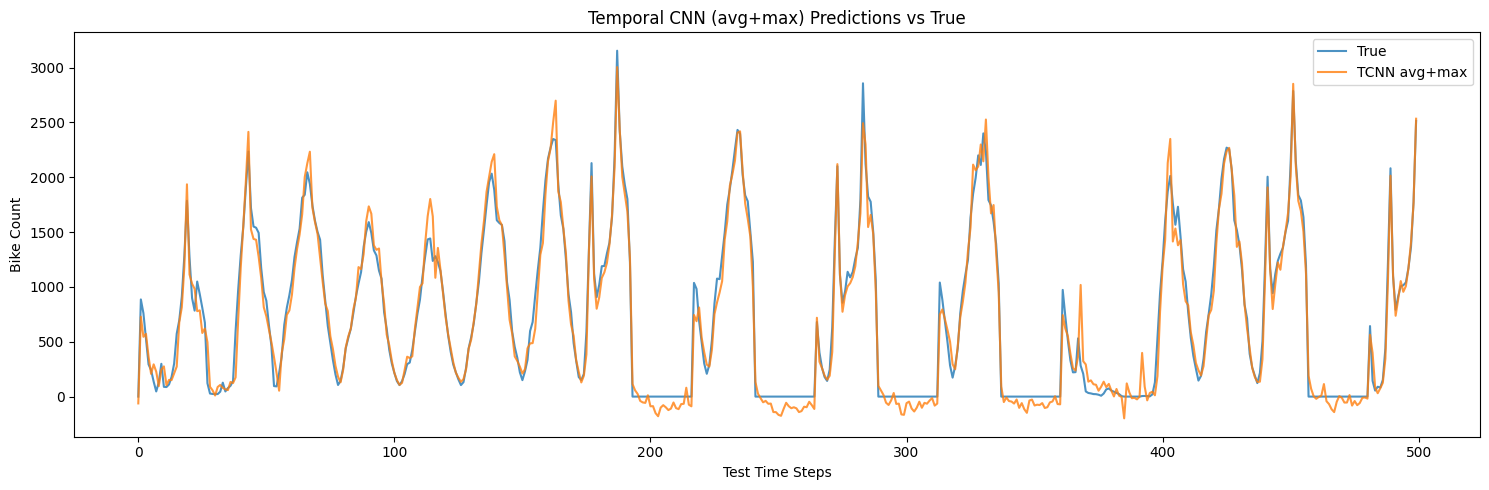

Temporal CNN (avg+max) training complete!


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN with avg + max pooling ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=80, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(2 * channels, 1)  

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.bn(x)
        x = torch.relu(x)                  # [B, C, T]

        avg_pool = x.mean(dim=2)           # [B, C]
        max_pool, _ = x.max(dim=2)         # [B, C]
        feats = torch.cat([avg_pool, max_pool], dim=1)  # [B, 2C]

        feats = self.dropout(feats)
        return self.fc(feats)              # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=80, dropout=0.3).to(device)
print(f"TemporalCNN (avg+max): input {n_features} feats -> 80 conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN (avg+max) TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN (avg+max) TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))3
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN avg+max', alpha=0.8)
plt.legend()
plt.title('Temporal CNN (avg+max) Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN (avg+max) training complete!")


TCNN+LSTM

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN+LSTM: input 20 feats -> 80 conv channels -> 80 LSTM hidden
Epoch 1/100: train 0.1550 | val 0.1246
Epoch 2/100: train 0.0853 | val 0.0729
Epoch 3/100: train 0.0602 | val 0.0764
Epoch 4/100: train 0.0540 | val 0.0630
Epoch 5/100: train 0.0469 | val 0.0549
Epoch 6/100: train 0.0449 | val 0.0680
Epoch 7/100: train 0.0418 | val 0.0468
Epoch 8/100: train 0.0381 | val 0.0475
Epoch 9/100: train 0.0395 | val 0.0542
Epoch 10/100: train 0.0385 | val 0.0523
Epoch 11/100: train 0.0376 | val 0.0479
Epoch 12/100: train 0.0360 | val 0.0655
Epoch 13/100: train 0.0331 | val 0.0576
Epoch 14/100: train 0.0324 | val 0.0439
Epoch 15/100: train 0.0347 | val 0.0476
Epoch 16/100: train 0.0341 | val 0.0468
Epoch 17/100: train 0.0313 | val 0.0764
Epoch 18/100: train 0.0347 | val 0.0675
Epoch 19/100: train 0.0303 | val 0.0634
Epoch 20/100: train 0.0309 | val 0.0491
Epoch 21/100: train 0.0309 | val 0.0491


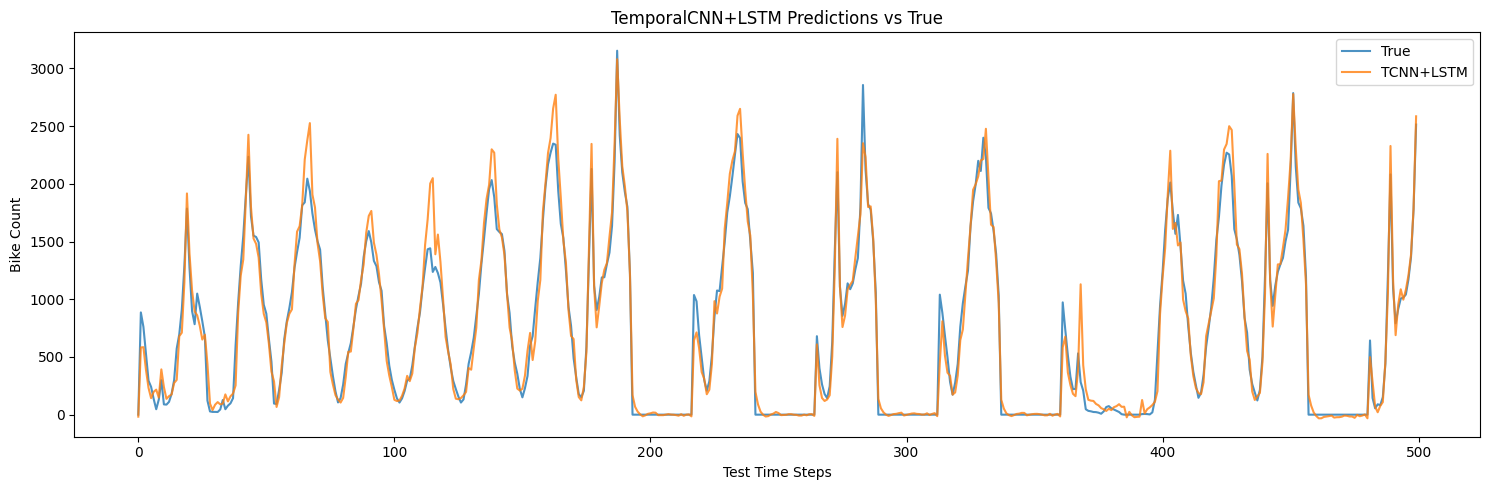

TemporalCNN+LSTM training complete!


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # cyclical encodings
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN + LSTM hybrid ---
class TemporalCNNLSTM(nn.Module):
    def __init__(self, input_size, channels=80, lstm_hidden=80, dropout=0.3):
        super().__init__()
        # CNN part
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)

        # LSTM over conv features
        self.lstm = nn.LSTM(
            input_size=channels,
            hidden_size=lstm_hidden,
            num_layers=1,
            batch_first=True
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)          # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.bn(x)
        x = torch.relu(x)              # [B, C, T]

        x = x.transpose(1, 2)          # [B, T, C] for LSTM

        lstm_out, (h_n, c_n) = self.lstm(x)
        final_h = h_n[-1]              # [B, H]

        final_h = self.dropout(final_h)
        return self.fc(final_h)        # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNNLSTM(input_size=n_features, channels=80, lstm_hidden=80, dropout=0.3).to(device)
print(f"TemporalCNN+LSTM: input {n_features} feats -> 80 conv channels -> 80 LSTM hidden")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== TemporalCNN+LSTM TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== TemporalCNN+LSTM TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN+LSTM', alpha=0.8)
plt.legend()
plt.title('TemporalCNN+LSTM Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("TemporalCNN+LSTM training complete!")


Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN (avg+max): input 20 feats -> 80 conv channels
Epoch 1/100: train 0.3450 | val 0.1702
Epoch 2/100: train 0.1706 | val 0.1712
Epoch 3/100: train 0.1396 | val 0.1537
Epoch 4/100: train 0.1390 | val 0.1764
Epoch 5/100: train 0.1223 | val 0.1099
Epoch 6/100: train 0.1078 | val 0.1026
Epoch 7/100: train 0.1004 | val 0.0641
Epoch 8/100: train 0.0987 | val 0.0719
Epoch 9/100: train 0.0863 | val 0.0512
Epoch 10/100: train 0.0851 | val 0.0918
Epoch 11/100: train 0.0814 | val 0.0503
Epoch 12/100: train 0.0800 | val 0.1112
Epoch 13/100: train 0.0776 | val 0.0559
Epoch 14/100: train 0.0689 | val 0.0548
Epoch 15/100: train 0.0667 | val 0.0481
Epoch 16/100: train 0.0650 | val 0.0529
Epoch 17/100: train 0.0670 | val 0.1432
Epoch 18/100: train 0.0647 | val 0.0727
Epoch 19/100: train 0.0598 | val 0.0496
Epoch 20/100: train 0.0606 | val 0.0606
Epoch 21/100: train 0.0604 | val 0.0666
Epoch 22/100:

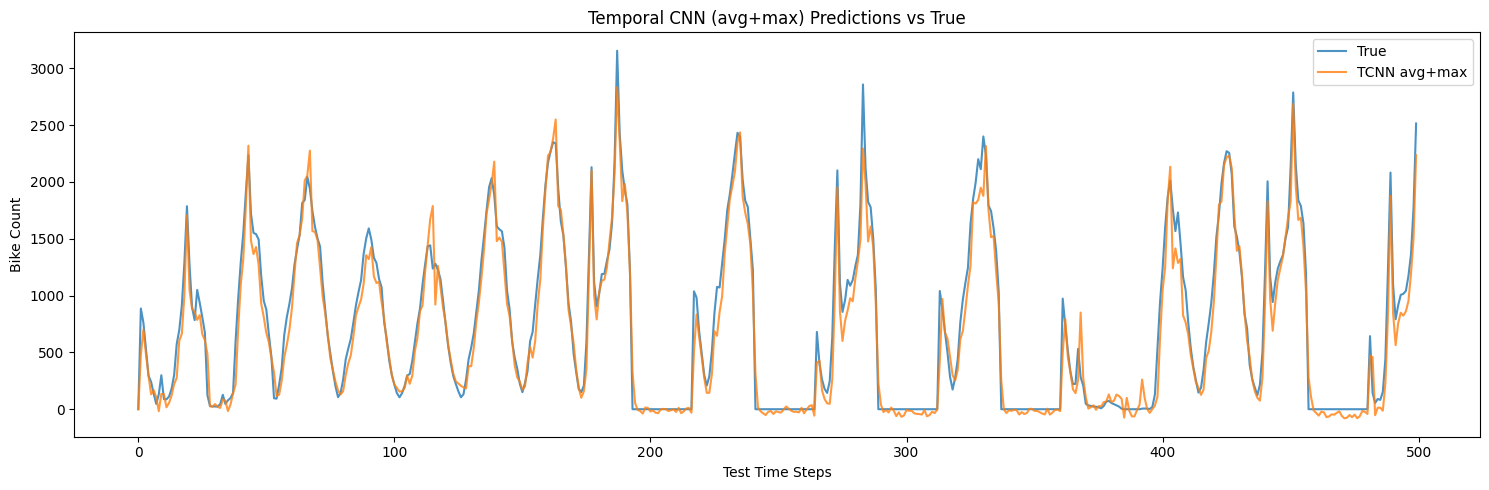

Temporal CNN (avg+max) training complete!


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN with avg + max pooling ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=80, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(2 * channels, 1)  

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.bn(x)
        x = torch.relu(x)                  # [B, C, T]

        avg_pool = x.mean(dim=2)           # [B, C]
        max_pool, _ = x.max(dim=2)         # [B, C]
        feats = torch.cat([avg_pool, max_pool], dim=1)  # [B, 2C]

        feats = self.dropout(feats)
        return self.fc(feats)              # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=80, dropout=0.3).to(device)
print(f"TemporalCNN (avg+max): input {n_features} feats -> 80 conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN (avg+max) TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN (avg+max) TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN avg+max', alpha=0.8)
plt.legend()
plt.title('Temporal CNN (avg+max) Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN (avg+max) training complete!")


Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN (avg+max): input 20 feats -> 80 conv channels
Epoch 1/100: train 0.3796 | val 0.4657
Epoch 2/100: train 0.2036 | val 0.3304
Epoch 3/100: train 0.1501 | val 0.1596
Epoch 4/100: train 0.1234 | val 0.1614
Epoch 5/100: train 0.1071 | val 0.0717
Epoch 6/100: train 0.1040 | val 0.0763
Epoch 7/100: train 0.0919 | val 0.0695
Epoch 8/100: train 0.0910 | val 0.0553
Epoch 9/100: train 0.0878 | val 0.0729
Epoch 10/100: train 0.0788 | val 0.0509
Epoch 11/100: train 0.0732 | val 0.0550
Epoch 12/100: train 0.0732 | val 0.0670
Epoch 13/100: train 0.0702 | val 0.0482
Epoch 14/100: train 0.0680 | val 0.0488
Epoch 15/100: train 0.0631 | val 0.0468
Epoch 16/100: train 0.0673 | val 0.0671
Epoch 17/100: train 0.0622 | val 0.0521
Epoch 18/100: train 0.0617 | val 0.0463
Epoch 19/100: train 0.0585 | val 0.0669
Epoch 20/100: train 0.0568 | val 0.0443
Epoch 21/100: train 0.0587 | val 0.0477
Epoch 22/100:

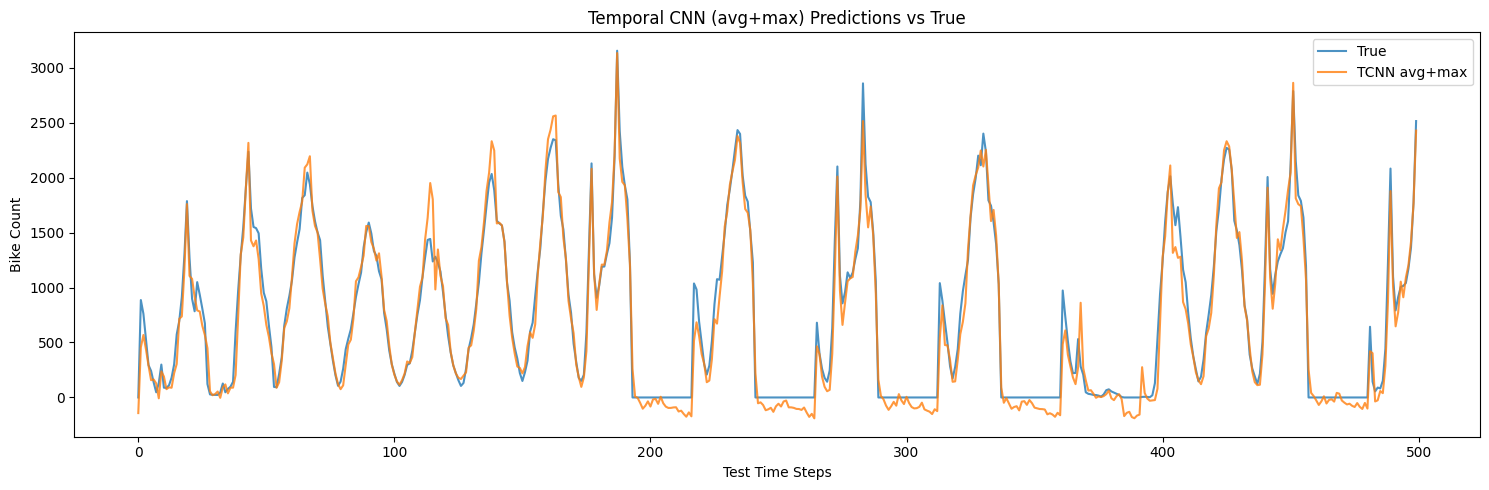

Temporal CNN (avg+max) training complete!


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN with avg + max pooling ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=80, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(2 * channels, 1)  

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.bn(x)
        x = torch.relu(x)                  # [B, C, T]

        avg_pool = x.mean(dim=2)           # [B, C]
        max_pool, _ = x.max(dim=2)         # [B, C]
        feats = torch.cat([avg_pool, max_pool], dim=1)  # [B, 2C]

        feats = self.dropout(feats)
        return self.fc(feats)              # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=80, dropout=0.3).to(device)
print(f"TemporalCNN (avg+max): input {n_features} feats -> 80 conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN (avg+max) TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN (avg+max) TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN avg+max', alpha=0.8)
plt.legend()
plt.title('Temporal CNN (avg+max) Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN (avg+max) training complete!")


adding residual blocks

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN Residual (avg+max): input 20 feats -> 80 conv channels
Epoch 1/100: train 0.6950 | val 0.2680
Epoch 2/100: train 0.2224 | val 0.2237
Epoch 3/100: train 0.1725 | val 0.1368
Epoch 4/100: train 0.1497 | val 0.1614
Epoch 5/100: train 0.1157 | val 0.0755
Epoch 6/100: train 0.0961 | val 0.0833
Epoch 7/100: train 0.0898 | val 0.0634
Epoch 8/100: train 0.0945 | val 0.1025
Epoch 9/100: train 0.0812 | val 0.0781
Epoch 10/100: train 0.0654 | val 0.0530
Epoch 11/100: train 0.0632 | val 0.0426
Epoch 12/100: train 0.0597 | val 0.0989
Epoch 13/100: train 0.0553 | val 0.0532
Epoch 14/100: train 0.0544 | val 0.0446
Epoch 15/100: train 0.0483 | val 0.0431
Epoch 16/100: train 0.0500 | val 0.0417
Epoch 17/100: train 0.0466 | val 0.0473
Epoch 18/100: train 0.0494 | val 0.0432
Epoch 19/100: train 0.0467 | val 0.0445
Epoch 20/100: train 0.0473 | val 0.0436
Epoch 21/100: train 0.0466 | val 0.0587
Epoc

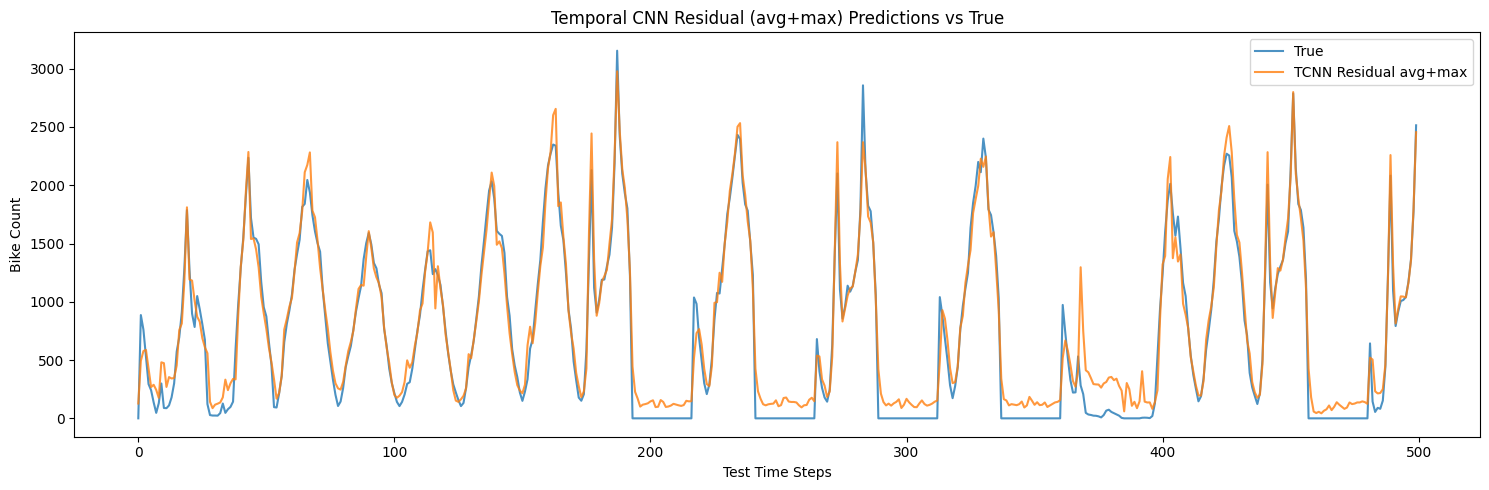

Temporal CNN Residual (avg+max) training complete!


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Residual Block ---
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=1):
        super().__init__()
        padding = dilation * (kernel_size - 1) // 2
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, 
                             padding=padding, dilation=dilation)
        self.bn = nn.BatchNorm1d(out_channels)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
    
    def forward(self, x):
        res = self.shortcut(x)
        out = torch.relu(self.bn(self.conv(x)))
        return torch.relu(out + res)  # Residual connection

# --- Temporal CNN with Residual Connections ---
class TemporalCNNResidual(nn.Module):
    def __init__(self, input_size, channels=80, dropout=0.3):
        super().__init__()
        # First conv to expand channels
        self.conv_in = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.bn_in = nn.BatchNorm1d(channels)
        
        # 3 Residual blocks with increasing dilation
        self.res1 = ResidualBlock(channels, channels, dilation=1)
        self.res2 = ResidualBlock(channels, channels, dilation=2)
        self.res3 = ResidualBlock(channels, channels, dilation=4)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(2 * channels, 1) 

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.bn_in(self.conv_in(x)))  # [B, C, T]
        
        x = self.res1(x)                   # Residual block 1
        x = self.res2(x)                   # Residual block 2 (dilation=2)
        x = self.res3(x)                   # Residual block 3 (dilation=4)
        
        avg_pool = x.mean(dim=2)           # [B, C]
        max_pool, _ = x.max(dim=2)         # [B, C]
        feats = torch.cat([avg_pool, max_pool], dim=1)  # [B, 2C]

        feats = self.dropout(feats)
        return self.fc(feats)              # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNNResidual(input_size=n_features, channels=80, dropout=0.3).to(device)
print(f"TemporalCNN Residual (avg+max): input {n_features} feats -> 80 conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN Residual (avg+max) TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN Residual (avg+max) TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN Residual avg+max', alpha=0.8)
plt.legend()
plt.title('Temporal CNN Residual (avg+max) Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN Residual (avg+max) training complete!")


Dilated convolutions

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN DILATED (avg+max): input 20 feats -> 80 conv channels
Dilations: [1, 2, 4] → Receptive field covers 168+ timesteps
Epoch 1/100: train 0.3555 | val 0.2994
Epoch 2/100: train 0.1884 | val 0.2017
Epoch 3/100: train 0.1406 | val 0.1472
Epoch 4/100: train 0.1237 | val 0.2011
Epoch 5/100: train 0.1199 | val 0.0938
Epoch 6/100: train 0.1083 | val 0.1876
Epoch 7/100: train 0.1078 | val 0.1839
Epoch 8/100: train 0.1052 | val 0.1885
Epoch 9/100: train 0.1009 | val 0.1944
Epoch 10/100: train 0.0926 | val 0.0971
Epoch 11/100: train 0.0999 | val 0.0585
Epoch 12/100: train 0.0993 | val 0.1680
Epoch 13/100: train 0.0946 | val 0.0814
Epoch 14/100: train 0.0907 | val 0.0736
Epoch 15/100: train 0.0861 | val 0.0716
Epoch 16/100: train 0.0817 | val 0.0708
Epoch 17/100: train 0.0806 | val 0.0658
Epoch 18/100: train 0.0747 | val 0.0565
Epoch 19/100: train 0.0820 | val 0.0634
Epoch 20/100: train 0.07

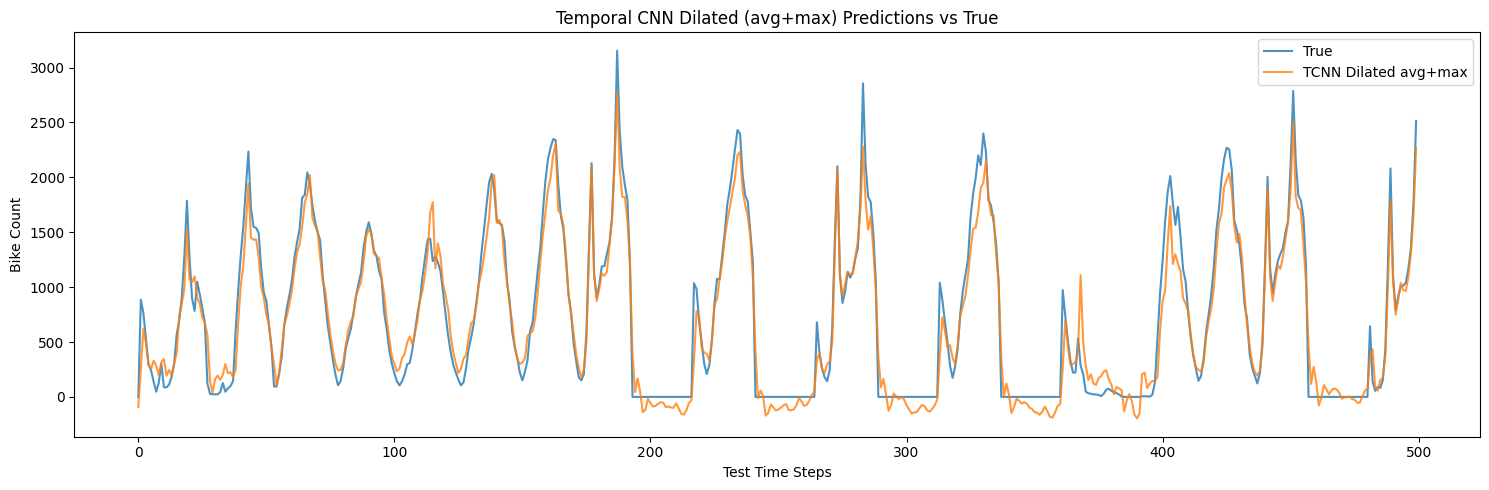

Temporal CNN Dilated (avg+max) training complete!


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN with DILATED Convolutions ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=80, dropout=0.3):
        super().__init__()
        # Dilated convolutions with increasing dilation rates [1,2,4]
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1, dilation=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=2, dilation=2)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=4, dilation=4)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(2 * channels, 1)  

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))      # dilation=1
        x = torch.relu(self.conv2(x))      # dilation=2
        x = torch.relu(self.conv3(x))      # dilation=4
        x = self.bn(x)
        x = torch.relu(x)                  # [B, C, T]

        avg_pool = x.mean(dim=2)           # [B, C]
        max_pool, _ = x.max(dim=2)         # [B, C]
        feats = torch.cat([avg_pool, max_pool], dim=1)  # [B, 2C]

        feats = self.dropout(feats)
        return self.fc(feats)              # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=80, dropout=0.3).to(device)
print(f"TemporalCNN DILATED (avg+max): input {n_features} feats -> 80 conv channels")
print("Dilations: [1, 2, 4] → Receptive field covers 168+ timesteps")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN DILATED (avg+max) TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN DILATED (avg+max) TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN Dilated avg+max', alpha=0.8)
plt.legend()
plt.title('Temporal CNN Dilated (avg+max) Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN Dilated (avg+max) training complete!")


Dilated convolutions v-2

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN Bottleneck-Dilated (avg+max): input 20 feats -> 80 conv channels
Epoch 1/100: train 0.4050 | val 0.3347
Epoch 2/100: train 0.1796 | val 0.0959
Epoch 3/100: train 0.1525 | val 0.0844
Epoch 4/100: train 0.1392 | val 0.0749
Epoch 5/100: train 0.1305 | val 0.1306
Epoch 6/100: train 0.1228 | val 0.1092
Epoch 7/100: train 0.1270 | val 0.2800
Epoch 8/100: train 0.1189 | val 0.0910
Epoch 9/100: train 0.1160 | val 0.0707
Epoch 10/100: train 0.1087 | val 0.0907
Epoch 11/100: train 0.1179 | val 0.0644
Epoch 12/100: train 0.1004 | val 0.0626
Epoch 13/100: train 0.1038 | val 0.0799
Epoch 14/100: train 0.1003 | val 0.1279
Epoch 15/100: train 0.0969 | val 0.0649
Epoch 16/100: train 0.0950 | val 0.0603
Epoch 17/100: train 0.0896 | val 0.0637
Epoch 18/100: train 0.0959 | val 0.0584
Epoch 19/100: train 0.0877 | val 0.0584
Epoch 20/100: train 0.0826 | val 0.0679
Epoch 21/100: train 0.0836 | val 0

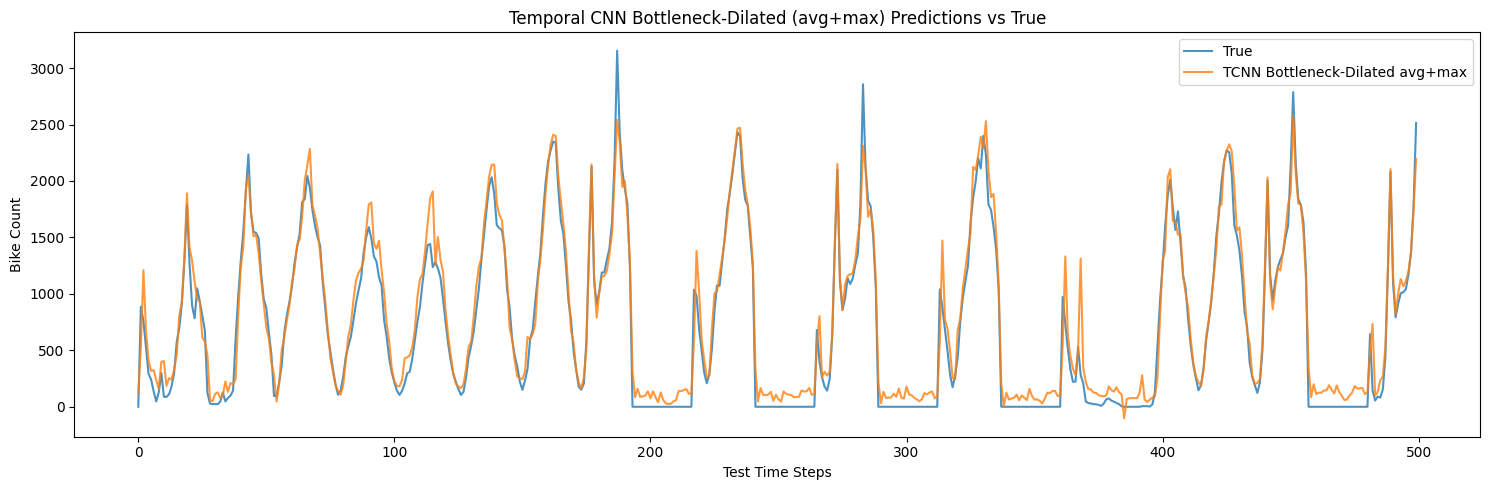

Temporal CNN Bottleneck-Dilated (avg+max) training complete!


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Bottleneck Dilated Temporal CNN with avg + max pooling ---
class TemporalCNNBottleneckDilated(nn.Module):
    def __init__(self, input_size, channels=80, bottleneck_ratio=0.5, dropout=0.3):
        super().__init__()
        bottleneck_channels = int(channels * bottleneck_ratio)

        # Input projection: F -> C
        self.in_conv = nn.Conv1d(input_size, channels, kernel_size=1)
        self.in_bn = nn.BatchNorm1d(channels)

        # Block 1: bottleneck + dilation=1
        self.b1_reduce = nn.Conv1d(channels, bottleneck_channels, kernel_size=1)
        self.b1_conv = nn.Conv1d(bottleneck_channels, bottleneck_channels,
                                 kernel_size=3, padding=1, dilation=1)
        self.b1_expand = nn.Conv1d(bottleneck_channels, channels, kernel_size=1)
        self.b1_bn = nn.BatchNorm1d(channels)

        # Block 2: bottleneck + dilation=2
        self.b2_reduce = nn.Conv1d(channels, bottleneck_channels, kernel_size=1)
        self.b2_conv = nn.Conv1d(bottleneck_channels, bottleneck_channels,
                                 kernel_size=3, padding=2, dilation=2)
        self.b2_expand = nn.Conv1d(bottleneck_channels, channels, kernel_size=1)
        self.b2_bn = nn.BatchNorm1d(channels)

        self.dropout = nn.Dropout(dropout)

        # Slightly richer MLP head
        self.head = nn.Sequential(
            nn.Linear(2 * channels, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)  # [B, F, T]

        # Input projection
        x = torch.relu(self.in_bn(self.in_conv(x)))  # [B, C, T]

        # Block 1 with residual
        res = x
        out = torch.relu(self.b1_reduce(x))
        out = torch.relu(self.b1_conv(out))
        out = self.b1_expand(out)
        out = self.b1_bn(out)
        x = torch.relu(out + res)

        # Block 2 with residual
        res = x
        out = torch.relu(self.b2_reduce(x))
        out = torch.relu(self.b2_conv(out))
        out = self.b2_expand(out)
        out = self.b2_bn(out)
        x = torch.relu(out + res)  # [B, C, T]

        # Global pooling
        avg_pool = x.mean(dim=2)        # [B, C]
        max_pool, _ = x.max(dim=2)      # [B, C]
        feats = torch.cat([avg_pool, max_pool], dim=1)  # [B, 2C]

        feats = self.dropout(feats)
        return self.head(feats)         # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNNBottleneckDilated(input_size=n_features, channels=80,
                                     bottleneck_ratio=0.5, dropout=0.3).to(device)
print(f"TemporalCNN Bottleneck-Dilated (avg+max): input {n_features} feats -> 80 conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN Bottleneck-Dilated (avg+max) TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN Bottleneck-Dilated (avg+max) TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN Bottleneck-Dilated avg+max', alpha=0.8)
plt.legend()
plt.title('Temporal CNN Bottleneck-Dilated (avg+max) Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN Bottleneck-Dilated (avg+max) training complete!")


Dilated convolutions v-3

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN Bottleneck-Dilated v2 (avg+max): input 20 feats -> 80 conv channels
Epoch 1/100: train 0.4165 | val 0.3048
Epoch 2/100: train 0.2132 | val 0.1646
Epoch 3/100: train 0.1724 | val 0.1148
Epoch 4/100: train 0.1617 | val 0.1726
Epoch 5/100: train 0.1468 | val 0.0987
Epoch 6/100: train 0.1292 | val 0.0800
Epoch 7/100: train 0.1186 | val 0.0817
Epoch 8/100: train 0.1205 | val 0.0765
Epoch 9/100: train 0.1221 | val 0.0948
Epoch 10/100: train 0.1172 | val 0.0837
Epoch 11/100: train 0.1037 | val 0.0716
Epoch 12/100: train 0.1098 | val 0.0763
Epoch 13/100: train 0.0985 | val 0.0865
Epoch 14/100: train 0.1004 | val 0.0752
Epoch 15/100: train 0.1043 | val 0.0711
Epoch 16/100: train 0.0931 | val 0.0855
Epoch 17/100: train 0.0953 | val 0.0714
Epoch 18/100: train 0.0919 | val 0.0949
Epoch 19/100: train 0.0946 | val 0.0956
Epoch 20/100: train 0.0914 | val 0.0717
Epoch 21/100: train 0.0971 | va

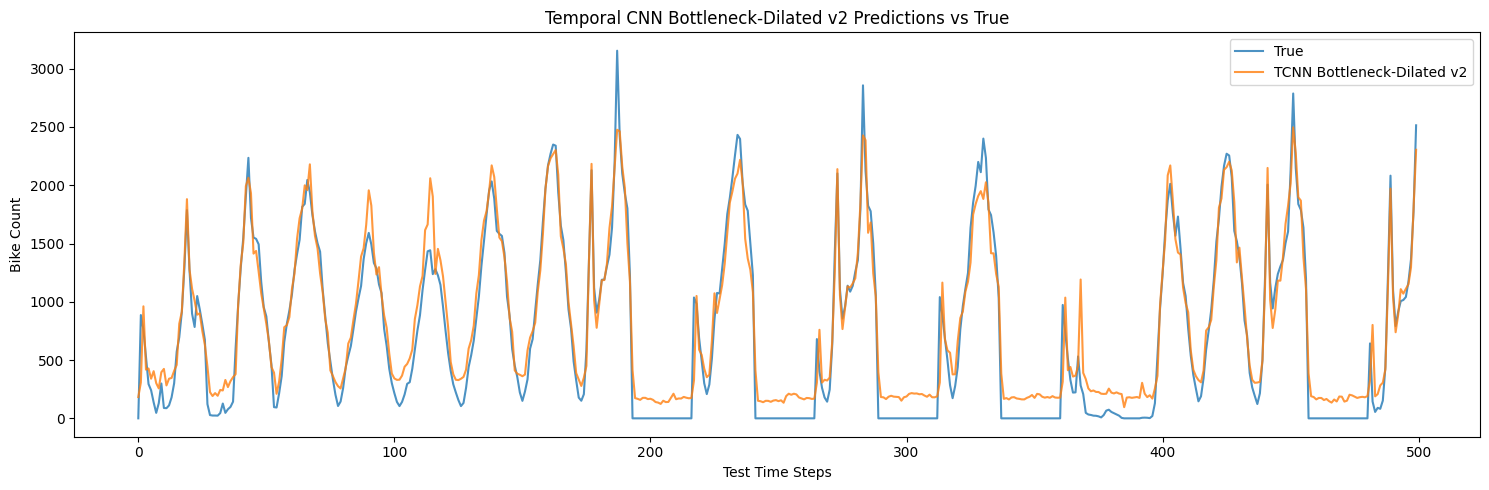

Temporal CNN Bottleneck-Dilated v2 training complete!


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Bottleneck Dilated Temporal CNN v2 (richer head + label noise) ---
class TemporalCNNBottleneckDilatedV2(nn.Module):
    def __init__(self, input_size, channels=80, bottleneck_ratio=0.5, dropout=0.3):
        super().__init__()
        bottleneck_channels = int(channels * bottleneck_ratio)

        # Input projection: F -> C
        self.in_conv = nn.Conv1d(input_size, channels, kernel_size=1)
        self.in_bn = nn.BatchNorm1d(channels)

        # Block 1: bottleneck + dilation=1
        self.b1_reduce = nn.Conv1d(channels, bottleneck_channels, kernel_size=1)
        self.b1_conv = nn.Conv1d(bottleneck_channels, bottleneck_channels,
                                 kernel_size=3, padding=1, dilation=1)
        self.b1_expand = nn.Conv1d(bottleneck_channels, channels, kernel_size=1)
        self.b1_bn = nn.BatchNorm1d(channels)

        # Block 2: bottleneck + dilation=2
        self.b2_reduce = nn.Conv1d(channels, bottleneck_channels, kernel_size=1)
        self.b2_conv = nn.Conv1d(bottleneck_channels, bottleneck_channels,
                                 kernel_size=3, padding=2, dilation=2)
        self.b2_expand = nn.Conv1d(bottleneck_channels, channels, kernel_size=1)
        self.b2_bn = nn.BatchNorm1d(channels)

        self.dropout = nn.Dropout(dropout)

        # Richer MLP head
        self.head = nn.Sequential(
            nn.Linear(2 * channels, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)  # [B, F, T]

        # Input projection
        x = torch.relu(self.in_bn(self.in_conv(x)))  # [B, C, T]

        # Block 1 with residual
        res = x
        out = torch.relu(self.b1_reduce(x))
        out = torch.relu(self.b1_conv(out))
        out = self.b1_expand(out)
        out = self.b1_bn(out)
        x = torch.relu(out + res)

        # Block 2 with residual
        res = x
        out = torch.relu(self.b2_reduce(x))
        out = torch.relu(self.b2_conv(out))
        out = self.b2_expand(out)
        out = self.b2_bn(out)
        x = torch.relu(out + res)  # [B, C, T]

        # Global pooling
        avg_pool = x.mean(dim=2)        # [B, C]
        max_pool, _ = x.max(dim=2)      # [B, C]
        feats = torch.cat([avg_pool, max_pool], dim=1)  # [B, 2C]

        feats = self.dropout(feats)
        return self.head(feats)         # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNNBottleneckDilatedV2(input_size=n_features, channels=80,
                                       bottleneck_ratio=0.5, dropout=0.3).to(device)
print(f"TemporalCNN Bottleneck-Dilated v2 (avg+max): input {n_features} feats -> 80 conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

label_noise_std = 0.03  # small noise on scaled y

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        # add small Gaussian noise to targets (regularization)
        noise = torch.randn_like(yb) * label_noise_std
        yb_noisy = yb + noise

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb_noisy)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN Bottleneck-Dilated v2 (avg+max) TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN Bottleneck-Dilated v2 (avg+max) TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN Bottleneck-Dilated v2', alpha=0.8)
plt.legend()
plt.title('Temporal CNN Bottleneck-Dilated v2 Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN Bottleneck-Dilated v2 training complete!")


High accuracy code plus MLP head

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN (avg+max + MLP head): input 20 feats -> 80 conv channels
Epoch 1/100: train 0.3699 | val 0.2955
Epoch 2/100: train 0.2147 | val 0.1763
Epoch 3/100: train 0.1616 | val 0.1257
Epoch 4/100: train 0.1288 | val 0.0989
Epoch 5/100: train 0.1263 | val 0.0621
Epoch 6/100: train 0.1082 | val 0.0608
Epoch 7/100: train 0.1069 | val 0.1304
Epoch 8/100: train 0.0954 | val 0.0727
Epoch 9/100: train 0.0966 | val 0.0801
Epoch 10/100: train 0.0951 | val 0.1139
Epoch 11/100: train 0.0869 | val 0.0938
Epoch 12/100: train 0.0991 | val 0.0595
Epoch 13/100: train 0.0846 | val 0.0693
Epoch 14/100: train 0.0823 | val 0.0701
Epoch 15/100: train 0.0763 | val 0.0600
Epoch 16/100: train 0.0784 | val 0.0525
Epoch 17/100: train 0.0831 | val 0.0624
Epoch 18/100: train 0.0807 | val 0.0491
Epoch 19/100: train 0.0777 | val 0.0862
Epoch 20/100: train 0.0759 | val 0.0521
Epoch 21/100: train 0.0752 | val 0.0791
Ep

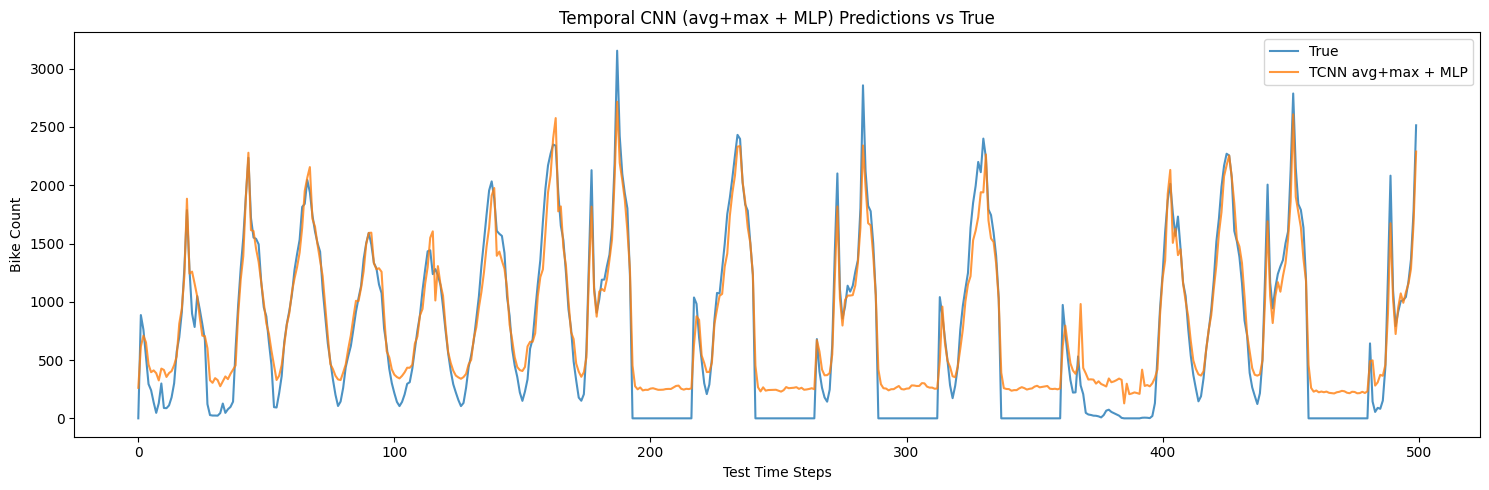

Temporal CNN (avg+max + MLP head) training complete!


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN with avg + max pooling + small MLP head ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=80, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        # MLP head instead of single Linear
        self.head = nn.Sequential(
            nn.Linear(2 * channels, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.bn(x)
        x = torch.relu(x)                  # [B, C, T]

        avg_pool = x.mean(dim=2)           # [B, C]
        max_pool, _ = x.max(dim=2)         # [B, C]
        feats = torch.cat([avg_pool, max_pool], dim=1)  # [B, 2C]

        feats = self.dropout(feats)
        return self.head(feats)            # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=80, dropout=0.3).to(device)
print(f"TemporalCNN (avg+max + MLP head): input {n_features} feats -> 80 conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN (avg+max + MLP head) TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN (avg+max + MLP head) TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN avg+max + MLP', alpha=0.8)
plt.legend()
plt.title('Temporal CNN (avg+max + MLP) Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN (avg+max + MLP head) training complete!")


High accuracy plus ensamble learninig by changing the seed value to see if the accycr improves 

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20

===== Training model with seed 0 =====
Seed 0 | Epoch 1/100: train 0.3980 | val 0.2578
Seed 0 | Epoch 2/100: train 0.2124 | val 0.1667
Seed 0 | Epoch 3/100: train 0.1594 | val 0.1210
Seed 0 | Epoch 4/100: train 0.1390 | val 0.1080
Seed 0 | Epoch 5/100: train 0.1186 | val 0.0588
Seed 0 | Epoch 6/100: train 0.1144 | val 0.1569
Seed 0 | Epoch 7/100: train 0.1032 | val 0.1434
Seed 0 | Epoch 8/100: train 0.0994 | val 0.0715
Seed 0 | Epoch 9/100: train 0.0938 | val 0.2073
Seed 0 | Epoch 10/100: train 0.1047 | val 0.0586
Seed 0 | Epoch 11/100: train 0.0907 | val 0.0801
Seed 0 | Epoch 12/100: train 0.0866 | val 0.0782
Seed 0 | Epoch 13/100: train 0.0841 | val 0.0608
Seed 0 | Epoch 14/100: train 0.0750 | val 0.0703
Seed 0 | Epoch 15/100: train 0.0762 | val 0.0757
Seed 0 | Epoch 16/100: train 0.0749 | val 0.0547
Seed 0 | Epoch 17/100: train 0.0757 | val 0.0667
Seed 0 | Epoch 18/100: train 0.0696 | 

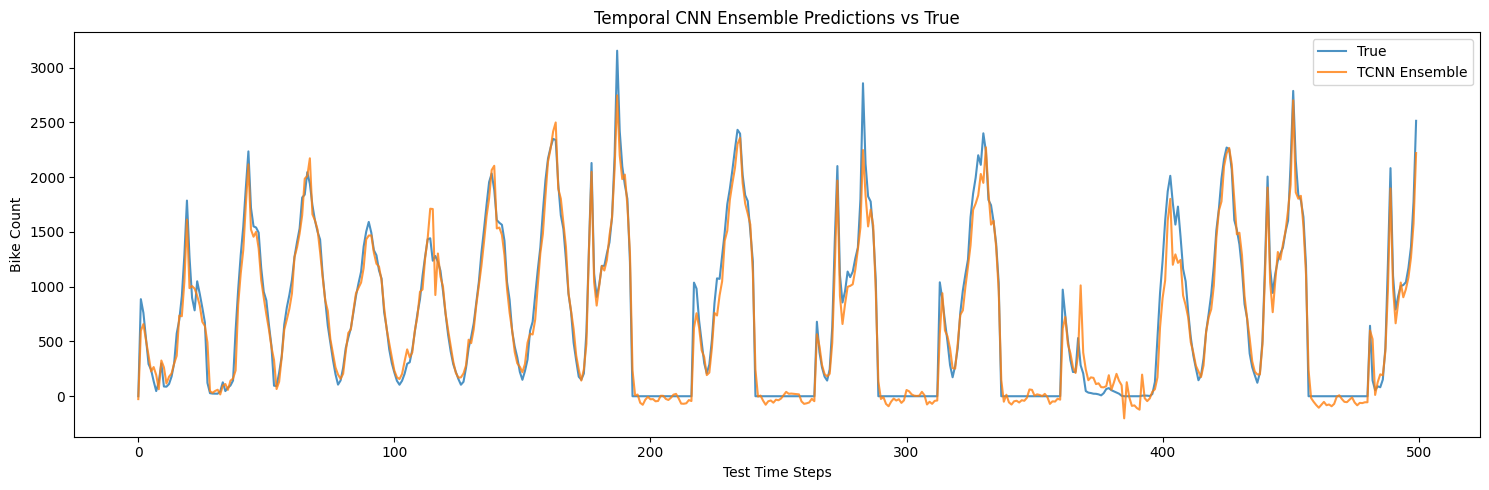

TCNN ensemble evaluation complete!


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ===================== Early stopping helper =====================
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# ===================== Data Prep (same as your base code) =====================
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# ===================== Base TCNN model (your best architecture) =====================
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=80, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(2 * channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.bn(x)
        x = torch.relu(x)                  # [B, C, T]

        avg_pool = x.mean(dim=2)           # [B, C]
        max_pool, _ = x.max(dim=2)         # [B, C]
        feats = torch.cat([avg_pool, max_pool], dim=1)  # [B, 2C]

        feats = self.dropout(feats)
        return self.fc(feats)              # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ===================== Train & save multiple seeds =====================
def train_one_seed(seed, save_path):
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = TemporalCNN(input_size=n_features, channels=80, dropout=0.3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
    criterion = nn.MSELoss()
    early_stopper = EarlyStopper(patience=10, min_delta=1e-4)
    epochs = 100

    print(f"\n===== Training model with seed {seed} =====")
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = evaluate_loss(model, val_loader, criterion, device)
        print(f"Seed {seed} | Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

        if early_stopper.step(val_loss):
            print(f"Seed {seed}: Early stopping at epoch {epoch+1}")
            break

    torch.save(model.state_dict(), save_path)
    print(f"Saved model (seed {seed}) to {save_path}")

# ensure output dir
os.makedirs("models_tcnn_ensemble", exist_ok=True)

seeds = [0, 1, 2]
model_paths = [f"models_tcnn_ensemble/tcnn_seed{seed}.pt" for seed in seeds]

for seed, path in zip(seeds, model_paths):
    if not os.path.exists(path):
        train_one_seed(seed, path)
    else:
        print(f"Model for seed {seed} already exists at {path}, skipping training.")

# ===================== Load models and evaluate ensemble =====================
models = []
for seed, path in zip(seeds, model_paths):
    m = TemporalCNN(input_size=n_features, channels=80, dropout=0.3).to(device)
    m.load_state_dict(torch.load(path, map_location=device))
    m.eval()
    models.append(m)
    print(f"Loaded model from {path}")

# --- Evaluation (individual and ensemble) ---
def evaluate_model(model, loader, scaler_y, name="Single"):
    y_true_all = []
    y_pred_all = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            y_true_all.append(yb.cpu().numpy())
            y_pred_all.append(preds.cpu().numpy())

    y_true_all = np.concatenate(y_true_all, axis=0)
    y_pred_all = np.concatenate(y_pred_all, axis=0)

    y_true_all_orig = scaler_y.inverse_transform(y_true_all)
    y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

    mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
    safe_idx = y_true_all_orig > 10
    mape = np.mean(
        np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
               y_true_all_orig[safe_idx])
    ) * 100
    smape = np.mean(
        2 * np.abs(y_pred_all_orig - y_true_all_orig) /
        (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
    ) * 100

    print(f"\n=== {name} TEST Results ===")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test MAPE: {mape:.2f}%")
    print(f"Test SMAPE: {smape:.2f}%")
    return y_true_all_orig, y_pred_all_orig

# Evaluate each single model
for i, m in enumerate(models):
    evaluate_model(m, test_loader, scaler_y, name=f"TCNN seed {seeds[i]}")

# Evaluate ensemble
y_true_all = []
y_pred_ens_all = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds_sum = 0
        for m in models:
            preds_sum += m(xb)
        preds_ens = preds_sum / len(models)
        y_true_all.append(yb.cpu().numpy())
        y_pred_ens_all.append(preds_ens.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_ens_all = np.concatenate(y_pred_ens_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_ens_all_orig = scaler_y.inverse_transform(y_pred_ens_all)

mse = np.mean((y_true_all_orig - y_pred_ens_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_ens_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_ens_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_ens_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_ens_all_orig) + 1e-8)
) * 100

print("\n=== TCNN Ensemble (3 seeds) TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

# Optional: plot first 500 points for ensemble
plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_ens_all_orig[:500], label='TCNN Ensemble', alpha=0.8)
plt.legend()
plt.title('Temporal CNN Ensemble Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()
print("TCNN ensemble evaluation complete!")


Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN (avg+max): input 20 feats -> 80 conv channels
Epoch 1/100: train 0.3650 | val 0.2473
Epoch 2/100: train 0.1866 | val 0.1826
Epoch 3/100: train 0.1257 | val 0.0856
Epoch 4/100: train 0.1147 | val 0.0769
Epoch 5/100: train 0.1090 | val 0.1015
Epoch 6/100: train 0.1024 | val 0.0796
Epoch 7/100: train 0.0850 | val 0.1149
Epoch 8/100: train 0.0885 | val 0.0960
Epoch 9/100: train 0.0825 | val 0.0600
Epoch 10/100: train 0.0773 | val 0.0534
Epoch 11/100: train 0.0682 | val 0.0537
Epoch 12/100: train 0.0744 | val 0.0510
Epoch 13/100: train 0.0685 | val 0.0700
Epoch 14/100: train 0.0594 | val 0.0511
Epoch 15/100: train 0.0606 | val 0.0535
Epoch 16/100: train 0.0614 | val 0.0401
Epoch 17/100: train 0.0545 | val 0.0496
Epoch 18/100: train 0.0599 | val 0.0586
Epoch 19/100: train 0.0601 | val 0.0463
Epoch 20/100: train 0.0558 | val 0.0435
Epoch 21/100: train 0.0488 | val 0.0489
Epoch 22/100:

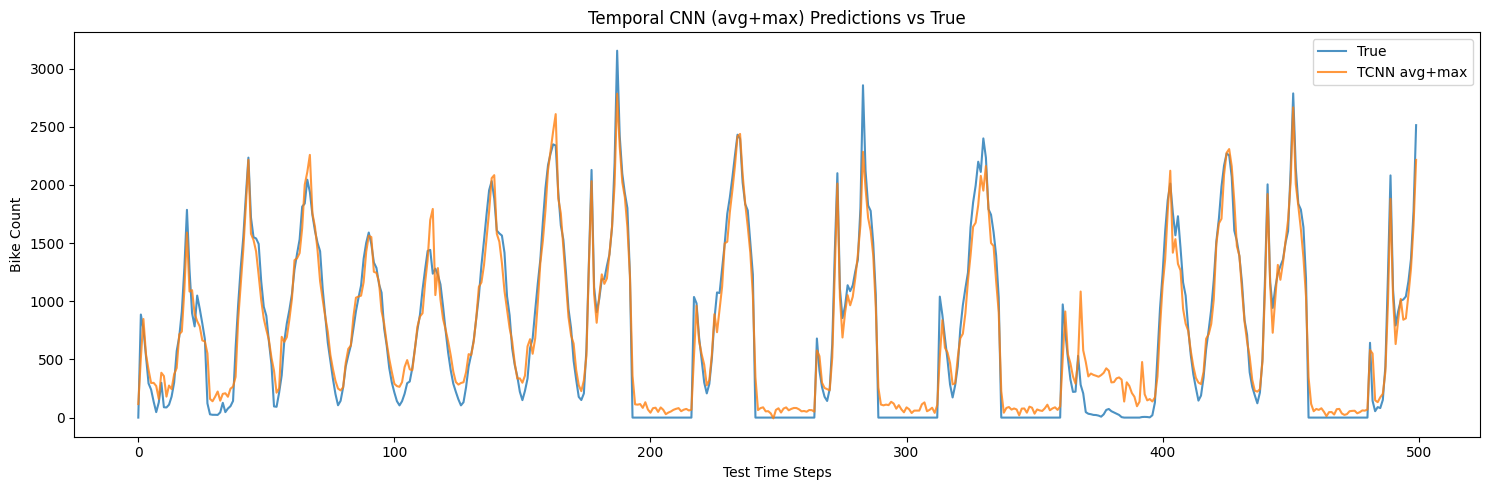

Temporal CNN (avg+max) training complete!


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN with avg + max pooling ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=80, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(2 * channels, 1)  

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.bn(x)
        x = torch.relu(x)                  # [B, C, T]

        avg_pool = x.mean(dim=2)           # [B, C]
        max_pool, _ = x.max(dim=2)         # [B, C]
        feats = torch.cat([avg_pool, max_pool], dim=1)  # [B, 2C]

        feats = self.dropout(feats)
        return self.fc(feats)              # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=80, dropout=0.3).to(device)
print(f"TemporalCNN (avg+max): input {n_features} feats -> 80 conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100
r2_tr = r2_score(y_train_true_orig, y_train_pred_orig)


print("\n=== Temporal CNN (avg+max) TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")
print(f"Train R2: {r2_tr:.4f}")


# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100
r2 = r2_score(y_true_all_orig, y_pred_all_orig)

print("\n=== Temporal CNN (avg+max) TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Train R2: {r2:.4f}")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN avg+max', alpha=0.8)
plt.legend()
plt.title('Temporal CNN (avg+max) Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN (avg+max) training complete!")


Shape: (8760, 14)
Date                         datetime64[ns]
Rented Bike Count                     int64
Hour                                  int64
Temperature(°C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(°C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
dtype: object
                                Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 00:00:00           0.000000     0.000000   
25%              2018-03-02 00:00:00         191.000000     5.75

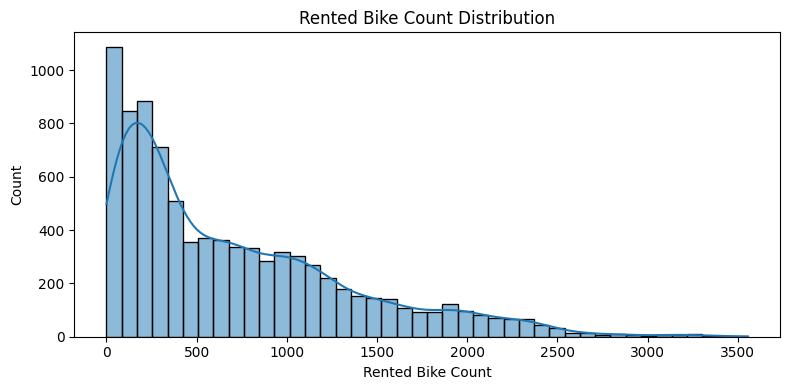

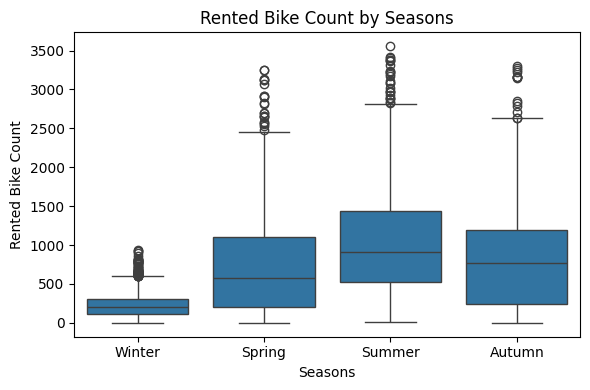

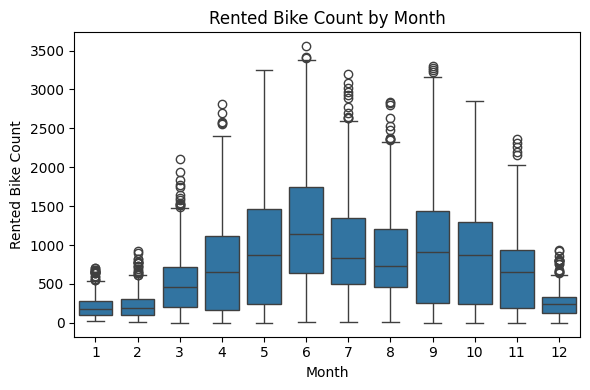

C:\Users\anavn\AppData\Local\Temp\ipykernel_4500\2202645415.py:86: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)


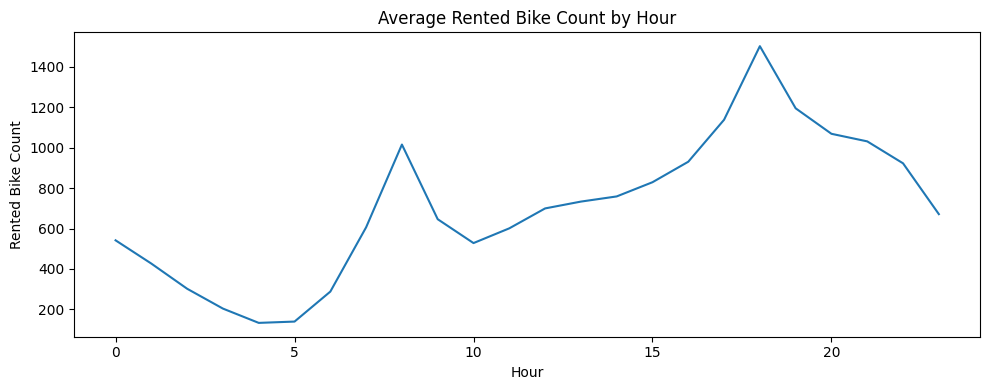

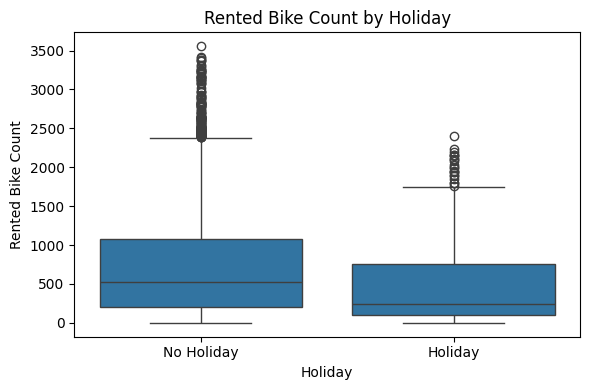

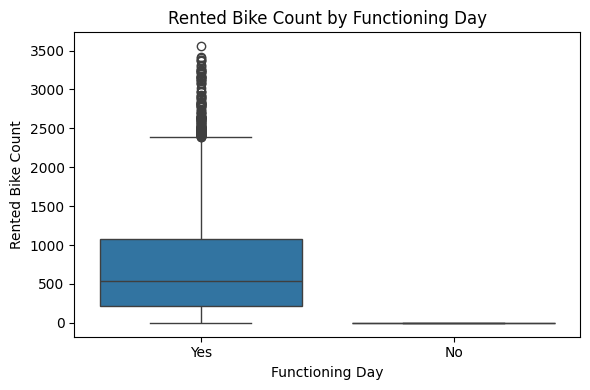

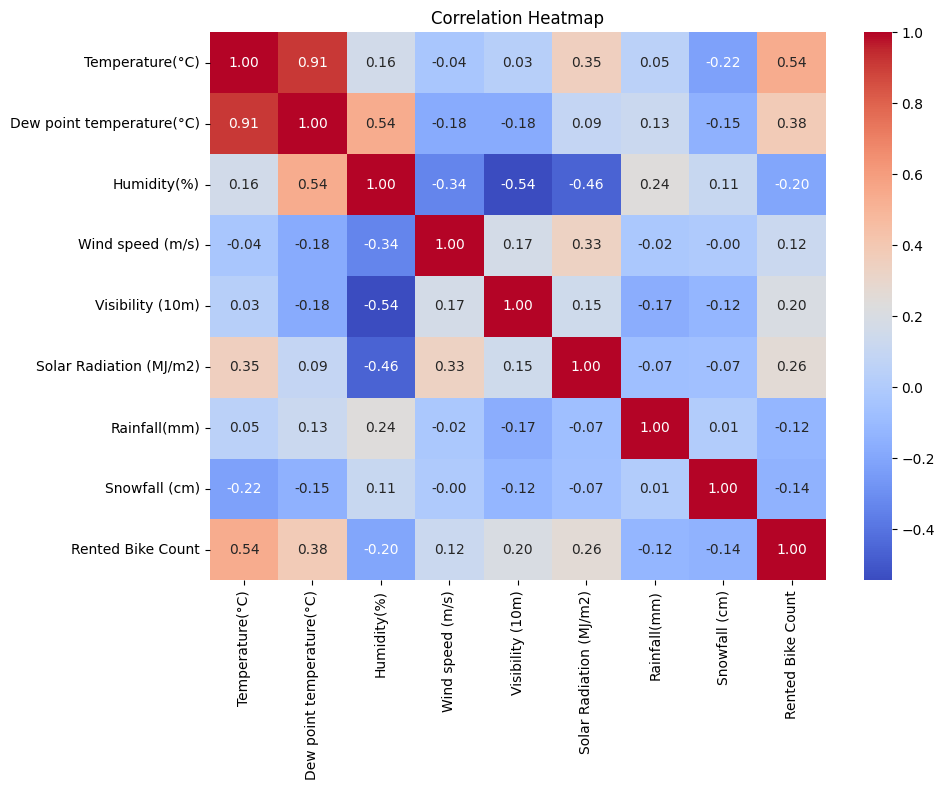

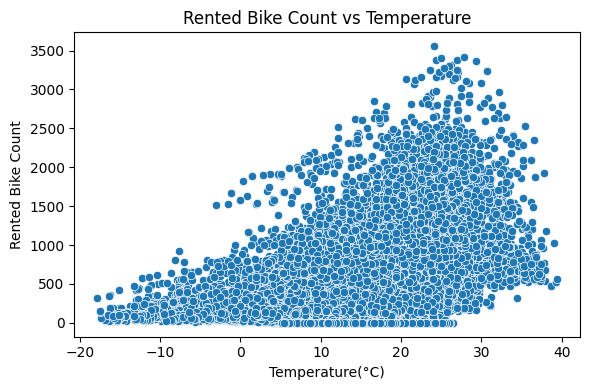

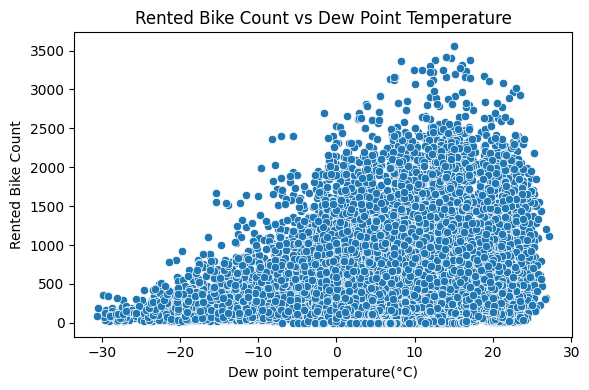

C:\Users\anavn\AppData\Local\Temp\ipykernel_4500\2202645415.py:134: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


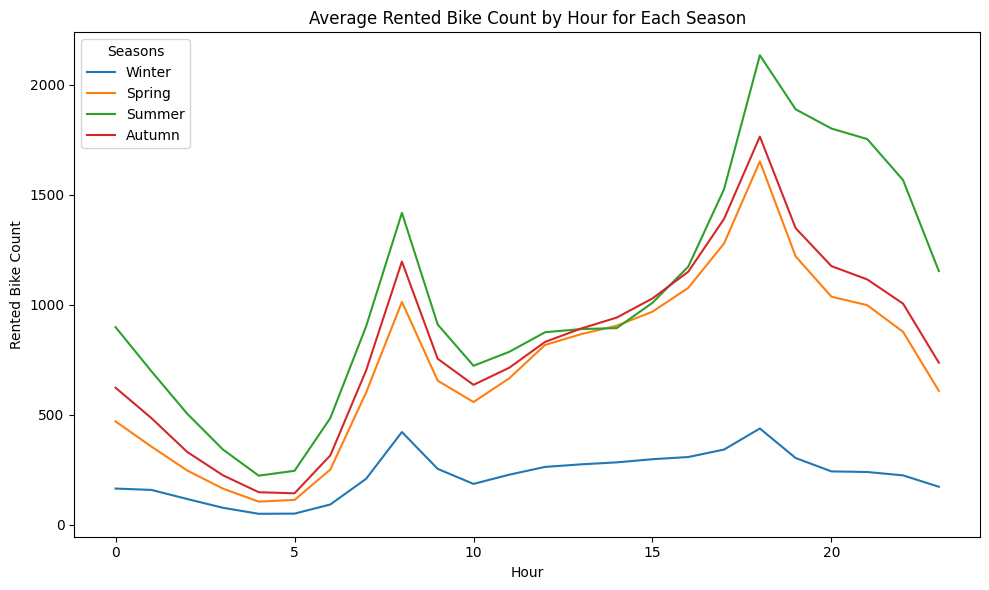

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN (avg+max): input 20 feats -> 80 conv channels
Epoch 1/100: train 0.3841 | val 0.2768
Epoch 2/100: train 0.1917 | val 0.2343
Epoch 3/100: train 0.1583 | val 0.1026
Epoch 4/100: train 0.1233 | val 0.0768
Epoch 5/100: train 0.1240 | val 0.0902
Epoch 6/100: train 0.1045 | val 0.0871
Epoch 7/100: train 0.0940 | val 0.0702
Epoch 8/100: train 0.0959 | val 0.0496
Epoch 9/100: train 0.0850 | val 0.0597
Epoch 10/100: train 0.0841 | val 0.0769
Epoch 11/100: train 0.0864 | val 0.0757
Epoch 12/100: train 0.0815 | val 0.0844
Epoch 13/100: train 0.0740 | val 0.0523
Epoch 14/100: train 0.0797 | val 0.0645
Epoch 15/100: train 0.0735 | val 0.0929
Epoch 16/100: train 0.0683 | val 0.0485
Epoch 17/100: train 0.0715 | val 0.0475
Epoch 18/100: train 0.0632 | val 0.0514
Epoch 19/100: train 0.0596 | val 0.0489
Epoch 20/100: train 0.0633 | val 0.0538
Epoch 21/100: train 0.0592 | val 0.0469
Epoch 22/100:

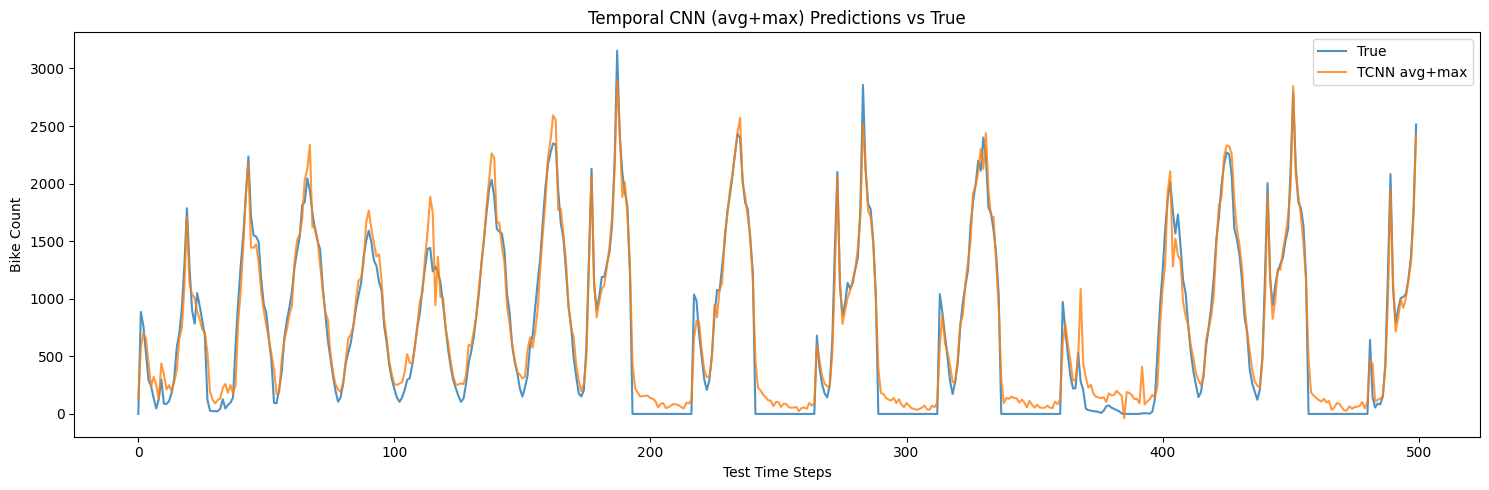

Temporal CNN (avg+max) training complete!


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- Early stopping helper ----------------
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)


# ---------------- 1. Load data ----------------
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')

# Basic cleaning like PPT: convert Date to datetime, etc.[file:1]
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)

target_col = 'Rented Bike Count'

# ---------------- 2. EDA (similar to PPT) ----------------
print("Shape:", df.shape)
print(df.dtypes)
print(df.describe())
print("Duplicated rows:", df.duplicated().sum())
print("Missing values:\n", df.isna().sum())

# Target distribution
plt.figure(figsize=(8, 4))
sns.histplot(df[target_col], kde=True)
plt.title('Rented Bike Count Distribution')
plt.tight_layout()
plt.show()

# Create Month, DayOfWeek, Weekend like PPT for EDA plots[file:1]
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Rented Bike Count by Seasons
plt.figure(figsize=(6, 4))
sns.boxplot(x='Seasons', y=target_col, data=df)
plt.title('Rented Bike Count by Seasons')
plt.tight_layout()
plt.show()

# By Month
plt.figure(figsize=(6, 4))
sns.boxplot(x='Month', y=target_col, data=df)
plt.title('Rented Bike Count by Month')
plt.tight_layout()
plt.show()

# By Hour
plt.figure(figsize=(10, 4))
sns.lineplot(x='Hour', y=target_col, data=df, estimator='mean', ci=None)
plt.title('Average Rented Bike Count by Hour')
plt.tight_layout()
plt.show()

# By Holiday
plt.figure(figsize=(6, 4))
sns.boxplot(x='Holiday', y=target_col, data=df)
plt.title('Rented Bike Count by Holiday')
plt.tight_layout()
plt.show()

# By Functioning Day
plt.figure(figsize=(6, 4))
sns.boxplot(x='Functioning Day', y=target_col, data=df)
plt.title('Rented Bike Count by Functioning Day')
plt.tight_layout()
plt.show()

# Correlation heatmap with key numeric variables[file:1]
num_cols = [
    'Temperature(°C)', 'Dew point temperature(°C)', 'Humidity(%)',
    'Wind speed (m/s)', 'Visibility (10m)',
    'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
    target_col
]
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Scatter vs Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Temperature')
plt.tight_layout()
plt.show()

# Scatter vs Dew Point Temperature
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Dew point temperature(°C)', y=target_col, data=df)
plt.title('Rented Bike Count vs Dew Point Temperature')
plt.tight_layout()
plt.show()

# Hourly pattern by season
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df,
    x='Hour',
    y=target_col,
    hue='Seasons',
    estimator='mean',
    ci=None
)
plt.title('Average Rented Bike Count by Hour for Each Season')
plt.tight_layout()
plt.show()

# ---------------- 3. Feature engineering ----------------
def add_engineered_features(df, max_lag=3):
    df = df.copy()
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)

    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})

    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

    df = df.dropna().reset_index(drop=True)
    return df


df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak',
    'is_low_demand_hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# ---------------- 4. Train / test split ----------------
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# ---------------- 5. Feature selection with XGBoost ----------------
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# ---------------- 6. Scaling ----------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# ---------------- 7. Sequence creation ----------------
def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len - 1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)


seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# Train/val split from training sequences
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# ---------------- 8. Temporal CNN model ----------------
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=80, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(2 * channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)           # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.bn(x)
        x = torch.relu(x)               # [B, C, T]

        avg_pool = x.mean(dim=2)        # [B, C]
        max_pool, _ = x.max(dim=2)      # [B, C]
        feats = torch.cat([avg_pool, max_pool], dim=1)  # [B, 2C]

        feats = self.dropout(feats)
        return self.fc(feats)           # [B, 1]


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=80, dropout=0.3).to(device)
print(f"TemporalCNN (avg+max): input {n_features} feats -> 80 conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---------------- 9. Training with early stopping ----------------
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break

# ---------------- 10. Evaluation on TRAIN set ----------------
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100
r2_tr = r2_score(y_train_true_orig, y_train_pred_orig)

print("\n=== Temporal CNN (avg+max) TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")
print(f"Train R2: {r2_tr:.4f}")

# ---------------- 11. Evaluation on TEST set ----------------
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100
r2 = r2_score(y_true_all_orig, y_pred_all_orig)

print("\n=== Temporal CNN (avg+max) TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Test R2: {r2:.4f}")

# ---------------- 12. Plot predictions ----------------
plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN avg+max', alpha=0.8)
plt.legend()
plt.title('Temporal CNN (avg+max) Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN (avg+max) training complete!")

